## Heart Attack Prediction Model 
## Preproceessing - Feature Engineering, Data Preparation
## Modeling - Baseline Modeling, Baseline Model Evaluations 

---


## Author: Will Wu

## Date: 2025-03-14
---

## **Table of Contents** ##
1. [Defining Metrics of Success](#1)
2. [Setup and Load Data](#2)
3. [Initial Feature Engineering](#3)
    - [Binning Data - `bmi`](#3a)
    - [Feature Selection](#3b)
4.  [Data Preparation](#4)
    - [Binary Encoding](#4a)
    - [Train-Test-Split](#4b)
    - [Log Transformation of Non-Normal Features](#4c)
    - [One-Hot Encoding](#4d)
    - [Handling Class Imbalance](#4e)
    - [Feature Scaling](#4f)
    - [Reducing Dimensionality using PCA](#4g)
     
5. [Baseline Modeling - Logistic Regression](#5)
    - [Logistic Regression With Imbalanced Class](#5a)
    - [Logistic Regression With Upsampling](#5b)
    - [Logistic Regression With Downsampling](#5c)
    - [Logistic Regression With Oversampling](#5d)
    - [Best Model Without Scaling](#5e)
    - [Best Model With PCA](#5f)
    - [Logistic Regression Baseline Modeling Summary](#5g)
6. [Baseline Modeling - Naive Bayes](#6)
    - [Naive Bayes With Imbalanced Class](#6a)
    - [Naive Bayes With Upsampling](#6b)
    - [Naive Bayes With Downsampling](#6c)
    - [Naive Bayes Baseline Modeling Summary](#6d)
7. [Baseline Modeling - Decision Tree](#7)
    - [Decision Tree With Imbalanced Class](#7a)
    - [Decision Tree With Upsampling](#7b)
    - [Decision Tree With Downsampling](#7c)
    - [Best Model with PCA](#7d)
    - [Decision Tree Baseline Modeling Summary](#7e)
8. [Baseline Modeling - Random Forest](#8)
    - [Random Forest With Imbalanced Class](#8a)
    - [Random Forest With Upsampling](#8b)
    - [Random Forest With Downsampling](#8c)
    - [Random Forest Baseline Modeling Summary](#8d)
9. [Baseline Modeling - XGBoost](#9)
    - [XGBoost With Imbalanced Class](#9a)
    - [XGBoost With Upsampling](#9b)
    - [XGBoost With Downsampling](#9c)
    - [XGBoost Baseline Modeling Summary](#9d)
10. [Comparison of Baseline Models and Summary](#10)
    - [Important/Predictive Features in Various Baseline Models](#10a)
    - [Model Comparison and Summary](#10b)
11. [Export Data](#11)



---

## 1. Defining Metrics of Success<a class="anchor" id="1"></a>

- The primary purpose of this notebook is to establish baseline models, which will involve feature engineering, data preparation, training various models, and model evaluations. Before diving into these steps, I will first define the metrics of success to help set the tone and direction of the modeling process.
- Given the highly imbalanced distribution of the target variable (94.7% negative vs. 5.3% positive), **accuracy is not a suitable metric**. A simple classifier that predicts all targets as negative would achieve an impressive accuracy of 94.7%, yet it would fail to identify any positive cases. Therefore, alternative metrics that better capture the model's performance on the minority class should be considered.
- Considering that the goal of this project is to create an early detection system for identifying the risk of a heart attack, the **primary objective** of the modeling is to achieve a **high recall score**. This metric evaluates the proportion of true positive cases identified by the classification model. Additionally, **precision** should be considered a **secondary goal**, as a model that predicts all negatives would generate a high number of false positive alerts, wasting users' time on unnecessary doctor visits or preventive medications, thus compromising the model's reliability.
- Therefore, the **success metrics should prioritize achieving a considerably high recall score while avoiding excessively low precision.**

---

## 2. Setup and Loading<a class="anchor" id="2"></a>

In [382]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif, f_regression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.utils import resample



In [383]:
# Setting figure size, fontsize globally in the notebook
plt.rcParams["figure.figsize"] = (6.0, 6.0)

# Set default grid
sns.set_style('darkgrid')

In [384]:
# Load the dataset
df = pd.read_csv("../data/processed/heart_attack_clean_final.csv")

In [385]:
# Check top 5 rows
df.head()

,year,sex,race_ethnicity_category,age_category,state,height,weight,bmi,alcohol_drinkers,general_health,...,difficulty_walking,difficulty_concentrating,difficulty_dressing_bathing,difficulty_errands,last_checkup_time,chest_scan,flu_vax,tetanus_vax,pneumo_vax,had_heart_attack
0,2022,Female,White,80+,Alabama,1.60,78.02,30.48,No,Very good,...,Yes,No,No,No,Past 1-2 years,not_asked,No,not_asked,No,No
1,2022,Female,White,80+,Alabama,1.45,59.87,28.48,No,Very good,...,No,No,No,No,Past 1-2 years,not_asked,Yes,not_asked,Yes,No
2,2022,Female,Black,80+,Alabama,1.63,58.97,22.20,No,Fair,...,Yes,Yes,No,No,Past year,not_asked,Yes,not_asked,Yes,No
3,2022,Female,White,75-79,Alabama,1.68,77.11,27.32,No,Very good,...,Yes,No,No,No,Past 2-5 years,not_asked,Yes,not_asked,Yes,No
4,2022,Female,White,75-79,Alabama,1.73,77.11,25.76,Yes,Fair,...,Yes,Yes,No,Yes,Past year,not_asked,No,not_asked,Yes,No


---

## 3. Initial Feature Engineering <a class="anchor" id="3"></a>

In [386]:
# Create a feature engineer df
df_engineer = df.copy()

### 3.1 Binning Data - `bmi`  <a class="anchor" id="3a"></a>

- From preliminary EDA, the distribution of `bmi` is slightly right-skewed, with notable outliers at the higher end. Therefore, converting bmi into bins could be beneficial in mitigating the impact of these outliers.
- According to the BMI definition, individuals are categorized as 'underweight' (bmi < 18.5), 'healthy' (18.5 <= bmi < 25), 'overweight' (25 <= bmi < 30), or 'obese' (bmi > 30). Preliminary EDA findings indicate that the boundary between 'healthy' and 'obese' (BMI of 25) is a critical point, with those below this threshold less likely to experience a heart attack. Thus, I aim to bin the numeric BMI values into categories to explore how the likelihood of having a heart attack varies. To approach this, I will:
    - Create a subset that stores `bmi`, target varaible `had_heart_attack`, and create a bmi_category column
    - Calculate the possibility of having a heart attack for each bmi_category
    - Visulize the possibility to see if there is any difference.

In [387]:
# Create a function that turns bmi into bins
def get_bmi_bin(bmi):
    """
    Return the BMI category based on the input bmi value.

    If bmi <= 0, raise ValueError.

    Args:
        bmi (float): Numeric BMI value.

    Returns:
        str: One of the following categories: 'underweight', 'healthy', 'overweight', 'obese'.

    """
    if bmi <= 0:
        raise ValueError('BMI cannot be less or equal to Zero.')

    match bmi:
        case _ if bmi < 18.5:
            return 'underweight'
        case _ if bmi < 25:
            return 'healthy'
        case _ if bmi < 30:
            return 'overweight'
        case _:
            return 'obese'


In [388]:
# Create a new subset with bmi and had_heart_attack
bmi_df = df_engineer[['bmi', 'had_heart_attack']].copy()

# Create a new column that maps bmi into category
bmi_df['bmi_category'] = bmi_df['bmi'].apply(get_bmi_bin)
bmi_df.head()

,bmi,had_heart_attack,bmi_category
0,30.48,No,obese
1,28.48,No,overweight
2,22.20,No,healthy
3,27.32,No,overweight
4,25.76,No,overweight


In [389]:
# Find the percentage of people who had heart_attack within each bmi_category
bmi_likelihood_df = (bmi_df.groupby('bmi_category')['had_heart_attack']\
                     .value_counts(normalize=True)*100).unstack()

bmi_likelihood_df

had_heart_attack,No,Yes
bmi_category,,
healthy,95.750308,4.249692
obese,93.860508,6.139492
overweight,94.667780,5.332220
underweight,94.787380,5.212620


In [390]:
# Calculate the Overall probability of having a heart attack
p_heart_attack = (bmi_df['had_heart_attack'].value_counts(normalize=True) * 100)
p_heart_attack = p_heart_attack['Yes']
print(f"The overall probability of having a heart attack {p_heart_attack:.2f}%")

The overall probability of having a heart attack 5.28%


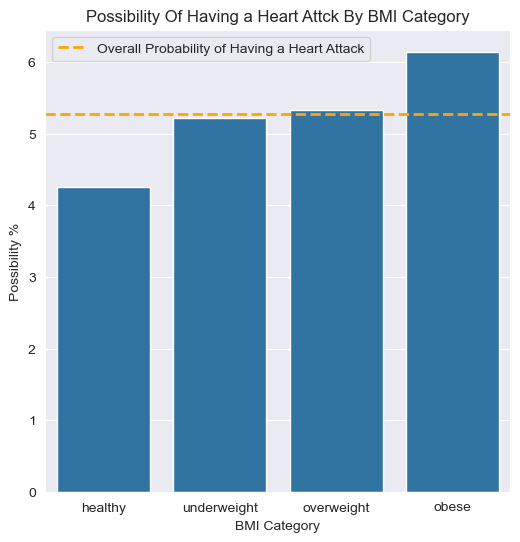

In [391]:
# Plot the likelihood of having a heart attack by bmi_category
plt.figure(figsize=(6, 6))

# Plot the likelihood of having a heart attack by each bmi_category
sns.barplot(x='bmi_category', y='Yes', data=bmi_likelihood_df.sort_values(by='Yes') )

# Plot the horizontal line of Overall probability of having a heart attack
plt.axhline(y=p_heart_attack, 
            ls='--', 
            lw=2, 
            color='orange', 
            label='Overall Probability of Having a Heart Attack'
            )
plt.title('Possibility Of Having a Heart Attck By BMI Category')
plt.xlabel('BMI Category')
plt.ylabel('Possibility %')
plt.xticks(rotation=0)
plt.legend()

plt.show()

**Takeaways**:
- The likelihood of having a heart attack differs across various BMI categories. The 'healthy' group shows a notably lower likelihood of experiencing a heart attack, while the 'obese' group exhibits a higher likelihood.
- Consequently, I will add a new feature, `bmi_category` to to categorize the `bmi` values.

In [392]:
# Create bmi_category column
bmi_category = df_engineer['bmi'].apply(get_bmi_bin)

# Insert the column into 8th position
df_engineer.insert(loc=8, column='bmi_category', value=bmi_category)

In [393]:
# Sanity Check
df_engineer['age_category'].isna().sum()

0

In [394]:
# Check the head of df
df_engineer.head().T

,0,1,2,3,4
year,2022,2022,2022,2022,2022
sex,Female,Female,Female,Female,Female
race_ethnicity_category,White,White,Black,White,White
age_category,80+,80+,80+,75-79,75-79
state,Alabama,Alabama,Alabama,Alabama,Alabama
height,1.6,1.45,1.63,1.68,1.73
weight,78.02,59.87,58.97,77.11,77.11
bmi,30.48,28.48,22.2,27.32,25.76
bmi_category,obese,overweight,healthy,overweight,overweight
alcohol_drinkers,No,No,No,No,Yes


---

### 3.2 Feature Selection <a class="anchor" id="3b"></a>


I will proceed to run various models using the full dataset without conducting feature selection at this stage. After evaluating the performance metrics, I will determine if feature selection or additional feature engineering are necessary.

---

## 4. Data Preparation  <a class="anchor" id="4"></a>

### 4.1 Binary Encoding <a class="anchor" id="4a"></a>

Transform binary columns into 1 and 0.

In [395]:
# Create a copy of df
df_encoded = df_engineer.copy()

Fetch binary columns, and print unique values within each binary column.

In [396]:
# Create an empty list
binary_cols = []

# Iterate each column, find the one that are both binary and categorical
for col in df.columns:
    if (df[col].nunique() == 2) & (df[col].dtype == 'object'):
        print(f'Column Name: {col}')
        print(f'Unique Values: {df[col].unique()}')
        print('----' * 8)

        # Append to the list
        binary_cols.append(col)



Column Name: sex
Unique Values: ['Female' 'Male']
--------------------------------
Column Name: physical_activities
Unique Values: ['No' 'Yes']
--------------------------------
Column Name: had_angina
Unique Values: ['No' 'Yes']
--------------------------------
Column Name: had_stroke
Unique Values: ['No' 'Yes']
--------------------------------
Column Name: had_asthma
Unique Values: ['No' 'Yes']
--------------------------------
Column Name: had_heart_attack
Unique Values: ['No' 'Yes']
--------------------------------


Most of the columns are 'Yes' and 'No' column, I will create dictionaries for mapping these columns into 1 and 0. Before encoding, I will first check the top for rows in df_encoded DataFrame.

In [397]:
# Check the head of df_encoded
df_encoded[binary_cols].head()

,sex,physical_activities,had_angina,had_stroke,had_asthma,had_heart_attack
0,Female,No,No,No,No,No
1,Female,Yes,No,No,No,No
2,Female,Yes,No,No,Yes,No
3,Female,Yes,No,No,No,No
4,Female,Yes,No,No,No,No


In [398]:
# Create dictionaries for mapping
yes_no = {
    'Yes' : 1,
    'No' : 0
}

is_female = {
    'Female' : 1,
    'Male' : 0
}

In [399]:
# Turn binary columns into binary values
for col in binary_cols:

    if col == 'sex': 
        df_encoded[col] = df_encoded[col].map(is_female)  # If the column is sex, use is_female for map
    else:
        df_encoded[col] = df_encoded[col].map(yes_no)   # Use yes_no for mapping other binary columns

In [400]:
# Sanity check
df_encoded[binary_cols].head()

,sex,physical_activities,had_angina,had_stroke,had_asthma,had_heart_attack
0,1,0,0,0,0,0
1,1,1,0,0,0,0
2,1,1,0,0,1,0
3,1,1,0,0,0,0
4,1,1,0,0,0,0


The binary encoding is successfully executed, I will rename `sex` to `is_female` for interpretation purpose. 

In [401]:
# Rename sex column
df_encoded = df_encoded.rename(columns={'sex' : 'is_female'})

In [402]:
# Sanity check
df_encoded.head(2)

,year,is_female,race_ethnicity_category,age_category,state,height,weight,bmi,bmi_category,alcohol_drinkers,...,difficulty_walking,difficulty_concentrating,difficulty_dressing_bathing,difficulty_errands,last_checkup_time,chest_scan,flu_vax,tetanus_vax,pneumo_vax,had_heart_attack
0,2022,1,White,80+,Alabama,1.60,78.02,30.48,obese,No,...,Yes,No,No,No,Past 1-2 years,not_asked,No,not_asked,No,0
1,2022,1,White,80+,Alabama,1.45,59.87,28.48,overweight,No,...,No,No,No,No,Past 1-2 years,not_asked,Yes,not_asked,Yes,0


---

### 4.2 Train-Test-Split   <a class="anchor" id="4b"></a>

In [403]:
# Load the data and split into X and y
X = df_encoded.loc[:, df_encoded.columns != 'had_heart_attack']
y = df_encoded['had_heart_attack']

In [404]:
# Check shape
print(f'Shape of X is {X.shape}')
print(f'Shape of y is {y.shape}')

Shape of X is (751985, 37)
Shape of y is (751985,)


In [405]:
# Remainder test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=1)

In [406]:
# Print the size and target varaible distribution
print(f'X_train shape: {X_train.shape}')
print(f'Percentage of rows had heart attack (train set) {(y_train.mean()):.2%}')

print(f'X_test shape: {X_test.shape}')
print(f'Percentage of rows had heart attack (test set) {(y_test.mean()):.2%}')

X_train shape: (563988, 37)
Percentage of rows had heart attack (train set) 5.28%
X_test shape: (187997, 37)
Percentage of rows had heart attack (test set) 5.28%


**Overview of Train, Validation, and Test set**:

| Dataset     | Rows | Cols (X + y)| Percentage of Had Heart Attack|
|-------------|------|------|---------------------------------|
| Train       | 563,988| 37 + 1   | 5.28%                             |
| Test        | 187,997 | 37 + 1  | 5.28%                             |

---

### 4.3 Log Transformation of Non-Normal Features <a class="anchor" id="4c"></a>

Based on the findings on preliminary EDA, I found that both `physical_health_days` and `mental_heanlth_days` have extremely right-skewed, non-normal distribution. In this section 

In [407]:
# Create a list of unnormal features
nonnormal_columns = ['physical_health_days', 'mental_health_days']

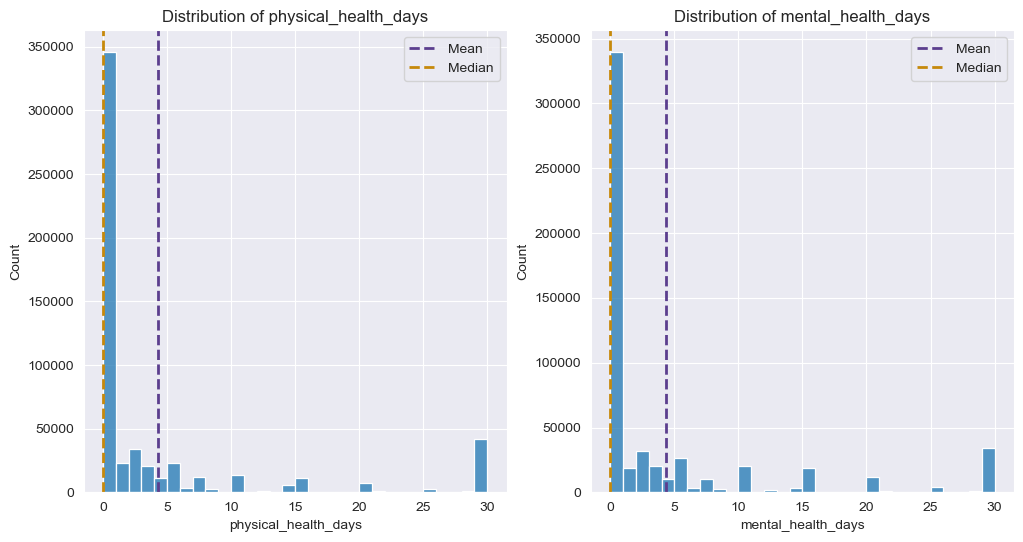

In [408]:
# Recap of physical_health_days and mental_health_days distributions
fig, axes = plt.subplots(1, 2, figsize=(12,6))

for idx, col in enumerate(nonnormal_columns):
    
    # Create the histogram
    sns.histplot(X_train[col], bins=30, ax=axes[idx])
    axes[idx].axvline(x=X_train[col].mean(), color='#5B3E8E', ls='--', lw=2, label='Mean')
    axes[idx].axvline(x=X_train[col].median(), color='#C6890B', ls='--', lw=2, label='Median')
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_ylabel(f'Count')
    axes[idx].legend()

plt.show()

In [409]:
# Instantiate Transformer
log_transformer = FunctionTransformer(func=np.log1p)

# Fit and Transform the training data
X_train[nonnormal_columns] = log_transformer.fit_transform(X_train[nonnormal_columns])

# Transform The X_test
X_test[nonnormal_columns] = log_transformer.transform(X_test[nonnormal_columns])

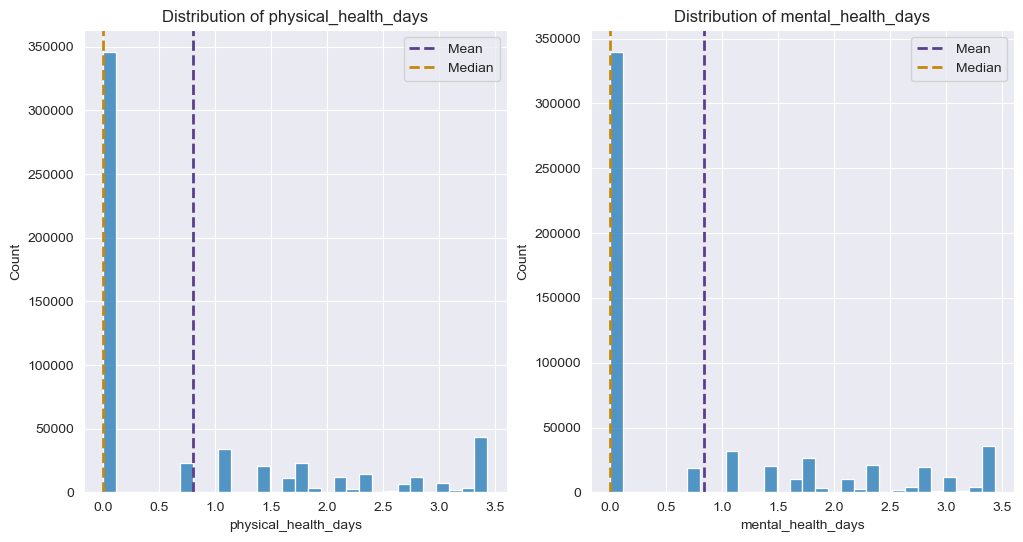

In [410]:
# Recap of physical_health_days and mental_health_days distributions
fig, axes = plt.subplots(1, 2, figsize=(12,6))

for idx, col in enumerate(nonnormal_columns):
    
    # Create the histogram
    sns.histplot(X_train[col], bins=30, ax=axes[idx])
    axes[idx].axvline(x=X_train[col].mean(), color='#5B3E8E', ls='--', lw=2, label='Mean')
    axes[idx].axvline(x=X_train[col].median(), color='#C6890B', ls='--', lw=2, label='Median')
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_ylabel(f'Count')
    axes[idx].legend()

plt.show()


Even though the distributions of `physical_health_days` and `mental_health_days` remain right-skewed after the log transformation, the data points are now more densely clustered together.

---

### 4.4 One-Hot Encoding <a class="anchor" id="4d"></a>

In [411]:
# Get the categorical and numeric columns
categorcal_columns = X_train.select_dtypes(include='object').columns.tolist()
numeric_columns = X_train.select_dtypes(include='number').columns.tolist()


In [412]:
# Calculate the sum of unique categories for all categorical columns
# Create a variable to store the cum sum and set zero
cumsum_categories = 0

for col in categorcal_columns:
    cumsum_categories += X_train[col].nunique()

print(f'Total number of categorical columns: {len(categorcal_columns)}. ')
print(f'Total number of unique categories within each categorical column: {cumsum_categories}. ')

Total number of categorical columns: 26. 
Total number of unique categories within each categorical column: 164. 


In [413]:
# Instantiate the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit transform the X_train categorical variables to array
encoded_array_train = encoder.fit_transform(X_train[categorcal_columns])

# Convert from arrary to DataFrame
encoded_df_train = pd.DataFrame(
    encoded_array_train, 
    columns=encoder.get_feature_names_out(categorcal_columns),
    index=X_train.index)


In [414]:
# Check encoded_df shape
print(f'After dropping one column within each categorical column, there should be 164 - 26 = {164-26} columns.')
print(f'The shape of one-hot-encoding DataFrame encoded_df: {encoded_df_train.shape}')

After dropping one column within each categorical column, there should be 164 - 26 = 138 columns.
The shape of one-hot-encoding DataFrame encoded_df: (563988, 138)


In [415]:
# Concatenate with encoded df
X_train_encoded = pd.concat([X_train[numeric_columns], encoded_df_train], axis=1)

KeyboardInterrupt: 

In [ ]:
# Sanity check
# Check if number of rows are consistent before and after one-hot-encoding
same_rows = (X_train.shape[0] == X_train_encoded.shape[0])

# Number of expected columns: Number of numeric columns + Number of dummy columns (after dropping one column per categorical column)
expected_column_count = len(numeric_columns) + cumsum_categories - len(categorcal_columns)
same_cols = (expected_column_count == X_train_encoded.shape[1])

# Print sanity check results
print(f'If X_train and X_train_encoded has same rows: {same_rows}')
print(f'If X_train_encoded has expected number of columns ({expected_column_count}): {same_rows}')

If X_train and X_train_encoded has same rows: True
If X_train_encoded has expected number of columns (149): True


The rows and columns on Train data after One Hot Encoding is consistent with expectations, I will now work on transformation of test data.


In [ ]:
# Transform X_test
encoded_array_test = encoder.transform(X_test[categorcal_columns])

# Convert array into DataFrame
encoded_df_test = pd.DataFrame(
    encoded_array_test, 
    columns=encoder.get_feature_names_out(categorcal_columns),
    index=X_test.index
    )

# Concatenate encoded_df_test with X_test numeric columns
X_test_encoded = pd.concat([X_test[numeric_columns], encoded_df_test], axis=1)

In [ ]:
# Sanity check
# Check if number of rows are consistent before and after one-hot-encoding
same_rows = (X_test.shape[0] == X_test_encoded.shape[0])

# Number of expected columns: Number of numeric columns + Number of dummy columns (after dropping one column per categorical column)
expected_column_count = len(numeric_columns) + (cumsum_categories - len(categorcal_columns))
same_cols = (expected_column_count == X_test_encoded.shape[1])

# Print sanity check results
print(f'If X_test and X_test_encoded has same rows: {same_rows}')
print(f'If X_test_encoded has expected number of columns ({expected_column_count}): {same_rows}')

If X_test and X_test_encoded has same rows: True
If X_test_encoded has expected number of columns (149): True


In [ ]:
# Set X_train and X_test equal to encoded DataFrames
X_train = X_train_encoded
X_test = X_test_encoded

One hot encoding has successfully been implemented on X_trian and X_test.

---

### 4.5 Handling Class Imbalance  <a class="anchor" id="4e"></a>


- The target variable in this dataset is highly imbalanced, which can pose challenges during training and evaluation. In this section, I will use both upsampling and downsampling techniques to rebalance the training data.
- I will implement oversampling for Class 1 to assess its effectiveness in boosting the recall score. This approach will increase the representation of Class 1, making it the majority class at 60%

**Upsampling**

In [ ]:
# Print number of class 1 and 0 sample before upsampling
print(f'Number of Class 1 samples before upsampling: {y_train.sum()}')
print(f'Number of Class 0 samples before upsampling: {y_train[y_train == 0].shape[0]}')

# Randomly duplicate class 1 observations
X_duplicate_positive, y_duplicate_positive = resample(
    X_train[y_train == 1],
    y_train[y_train == 1],
    replace=True,
    n_samples=X_train[y_train==0].shape[0],
    random_state=1
)

# Combine upsample with original data
X_train_upsampled = pd.DataFrame(
    np.vstack((X_train[y_train == 0], X_duplicate_positive)),
    columns=X_train.columns
    )

y_train_upsampled = np.hstack((y_train[y_train == 0], y_duplicate_positive))



# Print the number of class in after upsampling
print(f"\nNumber of Class 1 samples after upsampling: {y_train_upsampled.sum()}")
print(f"Number of Class 0 samples after upsampling: {y_train_upsampled.shape[0] - y_train_upsampled.sum()}")


Number of Class 1 samples before upsampling: 29762
Number of Class 0 samples before upsampling: 534226

Number of Class 1 samples after upsampling: 534226
Number of Class 0 samples after upsampling: 534226


---

**Downsampling**
#

In [ ]:
# Print the number of class 0 and class 1 sample before downsampling
print(f'Number of Class 0 sample before upsampling {y_train[y_train==0].shape[0]}')
print(f'Number of Class 1 sample before upsampling {y_train.sum()}')

# Randomly remove negative class 0 observations
X_remove_negative, y_remove_negative = resample(
    X_train[y_train == 0],
    y_train[y_train == 0],
    replace=True,
    n_samples=X_train_encoded[y_train == 1].shape[0],
    random_state=1
)

# Combine downsample with original dataset
X_train_downsampled = pd.DataFrame(
    np.vstack((X_train[y_train==1], X_remove_negative)), 
    columns=X_train.columns
    )
y_train_downsampled = np.hstack((y_train[y_train == 1], y_remove_negative))

# Print the number of class in after downsampling
print(f'Number of Class 0 sample after upsampling {y_train_downsampled[y_train_downsampled==0].shape[0]}')
print(f'Number of Class 1 sample before upsampling {y_train_downsampled.sum()}')


Number of Class 0 sample before upsampling 534226
Number of Class 1 sample before upsampling 29762
Number of Class 0 sample after upsampling 29762
Number of Class 1 sample before upsampling 29762


---

**Oversampling**

In [ ]:
# Print number of class 1 and 0 sample before upsampling
print(f'Number of Class 1 samples before oversampling: {y_train.sum()}')
print(f'Number of Class 0 samples before oversampling: {y_train[y_train == 0].shape[0]}')

# Randomly duplicate class 1 observations
X_duplicate_positive, y_duplicate_positive = resample(
    X_train[y_train == 1],
    y_train[y_train == 1],
    replace=True,
    n_samples=int((X_train[y_train==0].shape[0])*1.5),
    random_state=1
)

# Combine upsample with original data
X_train_oversampled = pd.DataFrame(
    np.vstack((X_train[y_train == 0], X_duplicate_positive)),
    columns=X_train.columns
    )
y_train_oversampled = np.hstack((y_train[y_train == 0], y_duplicate_positive))

# Print the number of class in after upsampling
print(f"\nNumber of Class 1 samples after upsampling: {y_train_oversampled.sum()}")
print(f"Number of Class 0 samples after upsampling: {y_train_oversampled.shape[0] - y_train_oversampled.sum()}")



Number of Class 1 samples before oversampling: 29762
Number of Class 0 samples before oversampling: 534226

Number of Class 1 samples after upsampling: 801339
Number of Class 0 samples after upsampling: 534226


---

### 4.6 Feature Scaling  <a class="anchor" id="4f"></a>

Standard scaling on original dataset.

In [ ]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Fit the scaler
scaler.fit(X_train)

# Transform X_train X_val X_test
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Standard scaling on upsampling dataset

In [ ]:
# Instantiate StandardScaler
scaler_upsampled = StandardScaler()

# Fit the scaler
scaler_upsampled.fit(X_train_upsampled)

# Transform X_train X_val X_test
X_train_scaled_upsampled = scaler_upsampled.transform(X_train_upsampled)
X_test_scaled_upsampled = scaler_upsampled.transform(X_test)

Standard scaling on downsampling dataset

In [ ]:
# Instantiate StandardScaler
scaler_downsampled = StandardScaler()

# Fit the scaler
scaler_downsampled.fit(X_train_downsampled)

# Transform X_train X_val X_test
X_train_scaled_downsampled = scaler_downsampled.transform(X_train_downsampled)
X_test_scaled_downsampled = scaler_downsampled.transform(X_test)

Standard scaling on oversampling dataset

In [ ]:
# Instantiate StandardScaler
scaler_oversampled = StandardScaler()

# Fit the scaler
scaler_oversampled.fit(X_train_oversampled)

# Transform X_train X_val X_test
X_train_scaled_oversampled = scaler_oversampled.transform(X_train_oversampled)
X_test_scaled_oversampled = scaler_oversampled.transform(X_test)

---

### 4.6 Reducing Dimensionality using PCA  <a class="anchor" id="4g"></a>

In [ ]:
# Get the shape of X_train
print(f'The dimension of X_train_scaled is: {X_train_scaled_upsampled.shape}')

The dimension of X_train_scaled is: (1068452, 149)


Find and plot the cumulative sum of variance explained by PC.

In [ ]:
# Instantiate PCA with 
imbalanced_pca = PCA(n_components=0.9)

# Fit PCA
imbalanced_pca.fit(X_train_scaled)

# Transform
X_train_pca = imbalanced_pca.transform(X_train_scaled)
X_test_pca = imbalanced_pca.transform(X_test_scaled)

In [ ]:
# Get the number 
num_pc = imbalanced_pca.n_components_

# Calculate the cumsum of explained variance
cumsum_pca = imbalanced_pca.explained_variance_ratio_.cumsum()

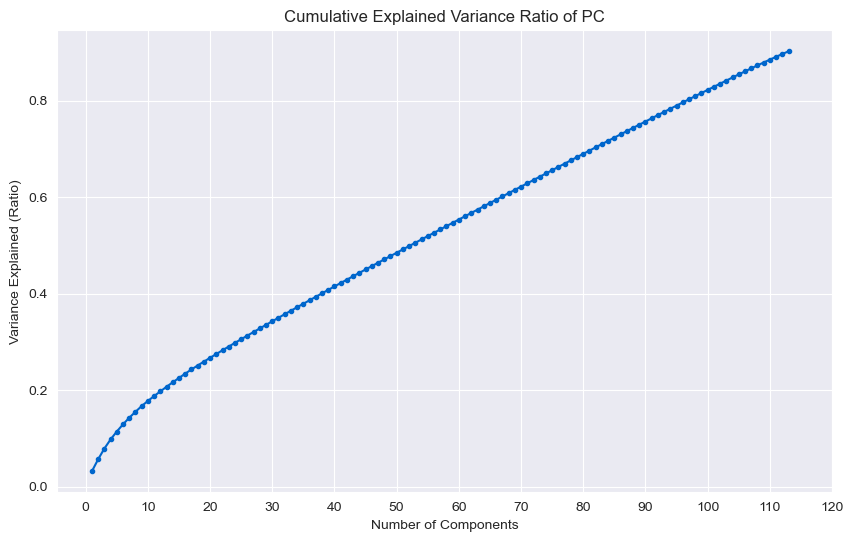

In [ ]:
# Plot the cumsum of variance explained
plt.figure(figsize=(10,6))
plt.plot(range(1, num_pc+1), cumsum_pca, marker='.', c='#0066CC')
plt.title('Cumulative Explained Variance Ratio of PC')
plt.ylabel('Variance Explained (Ratio)')
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, num_pc+10, 10))

plt.show()

- PCA for the upsampled Data

In [ ]:
# Instantiate PCA for upsampled data
upsampled_pca = PCA(n_components=0.9)

# Fit PCA
upsampled_pca.fit(X_train_scaled_upsampled)

# Transform
X_train_pca_upsampled = upsampled_pca.transform(X_train_scaled_upsampled)
X_test_pca_upsampled = upsampled_pca.transform(X_test_scaled_upsampled)

- PCA for the downsampled Data

In [ ]:
# Instantiate PCA for upsampled data
downsampled_pca = PCA(n_components=0.9)

# Fit PCA on the scaled downsampled training data
downsampled_pca.fit(X_train_scaled_downsampled)

# Transform both the training and test datasets using the fitted PCA
X_train_pca_downsampled = downsampled_pca.transform(X_train_scaled_downsampled)
X_test_pca_downsampled = downsampled_pca.transform(X_test_scaled_downsampled)

---

## 5. Baseline Modeling -  Logistic Regression <a class="anchor" id="5"></a>

### 5.1 Logistic Regression With Imbalanced Class (with class imbalance and scaling, without PCA) <a class="anchor" id="5a"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

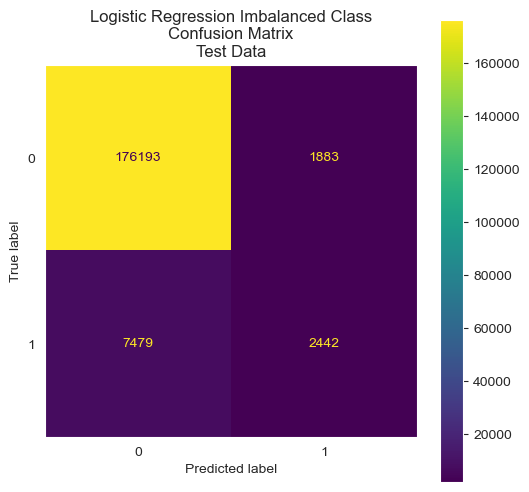

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.96      0.99      0.97    178076
           1       0.56      0.25      0.34      9921

    accuracy                           0.95    187997
   macro avg       0.76      0.62      0.66    187997
weighted avg       0.94      0.95      0.94    187997

Accuracy Score:
Train: 0.950
Test: 0.950 
Precision Score:
Train: 0.571
Test: 0.565 
Recall Score:
Train: 0.246
Test: 0.246 
F1 Score:
Train: 0.344
Test: 0.343 
AUC Score:
Train: 0.887
Test: 0.884 


In [ ]:
###############
#MODEL FITTING#
###############

# Imbalanced Data
logit_imbalanced = LogisticRegression(max_iter=1000, random_state=42)
logit_imbalanced.fit(X_train_scaled, y_train)

# Hard Predictions for train and test data
y_pred_train = logit_imbalanced.predict(X_train_scaled)
y_pred_test = logit_imbalanced.predict(X_test_scaled)

# Predicted probabilities for train and test data
y_pred_proba_train = logit_imbalanced.predict_proba(X_train_scaled)[:, 1]
y_pred_proba_test = logit_imbalanced.predict_proba(X_test_scaled)[:, 1]


##################
#Model Evaluation#
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(logit_imbalanced, X_test_scaled, y_test)
plt.title('Logistic Regression Imbalanced Class\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test)
print('Test Data classification report: ', print_line, report_original)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train, y_pred_train):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train, y_pred_train):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train, y_pred_train):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train, y_pred_train):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train, y_pred_proba_train):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

### 5.2 Logistic Regression With Upsampling (scaled, without PCA) <a class="anchor" id="5b"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

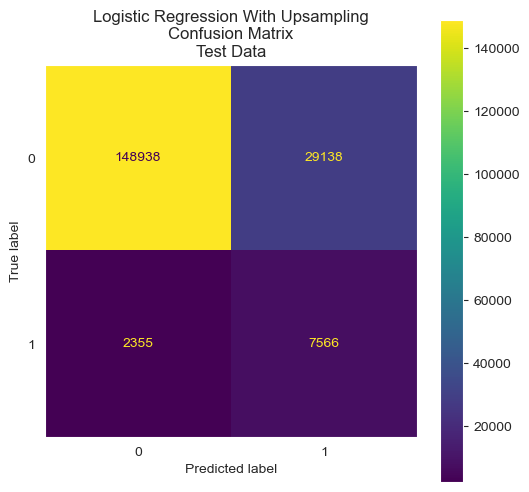

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.84      0.90    178076
           1       0.21      0.76      0.32      9921

    accuracy                           0.83    187997
   macro avg       0.60      0.80      0.61    187997
weighted avg       0.94      0.83      0.87    187997

Accuracy Score:
Train: 0.802
Test: 0.832 
Precision Score:
Train: 0.825
Test: 0.206 
Recall Score:
Train: 0.767
Test: 0.763 
F1 Score:
Train: 0.795
Test: 0.325 
AUC Score:
Train: 0.888
Test: 0.885 


In [ ]:
###############
#MODEL FITTING#
###############

# Upsampled Data
logit_upsampled = LogisticRegression(max_iter=1000, random_state=42)
logit_upsampled.fit(X_train_scaled_upsampled, y_train_upsampled)

# Hard Predictions for train and test data
y_pred_train = logit_upsampled.predict(X_train_scaled_upsampled)
y_pred_test = logit_upsampled.predict(X_test_scaled_upsampled)

# Predicted probabilities for train and test data
y_pred_proba_train = logit_upsampled.predict_proba(X_train_scaled_upsampled)[:, 1]
y_pred_proba_test = logit_upsampled.predict_proba(X_test_scaled_upsampled)[:, 1]

##################
#Model Evaluation#
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(logit_upsampled, X_test_scaled_upsampled, y_test)
plt.title('Logistic Regression With Upsampling\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test)
print('Test Data classification report: ', print_line, report_original)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_upsampled,y_pred_train):.3f}')
print(f'Test: {accuracy_score(y_test,y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_upsampled, y_pred_train):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_upsampled, y_pred_train):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_upsampled, y_pred_train):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_upsampled, y_pred_proba_train):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

### 5.3 Logistic Regression With Downsampling (scaled, without PCA) <a class="anchor" id="5c"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

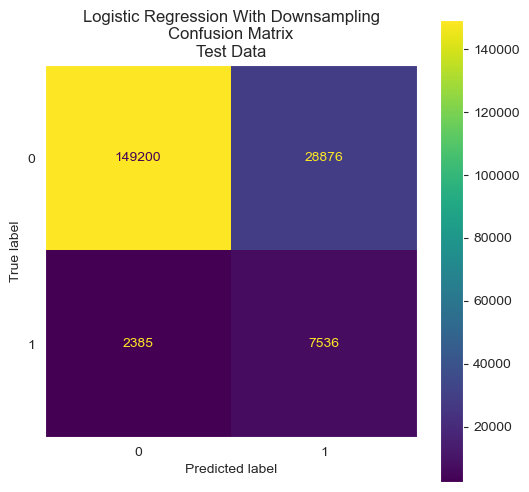

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.84      0.91    178076
           1       0.21      0.76      0.33      9921

    accuracy                           0.83    187997
   macro avg       0.60      0.80      0.62    187997
weighted avg       0.94      0.83      0.87    187997

Accuracy Score:
Train: 0.801
Test: 0.834 
Precision Score:
Train: 0.825
Test: 0.207 
Recall Score:
Train: 0.765
Test: 0.760 
F1 Score:
Train: 0.794
Test: 0.325 
AUC Score:
Train: 0.888
Test: 0.884 


In [ ]:
###############
# MODEL FITTING #
###############

# Downsampled Data
logit_downsampled = LogisticRegression(max_iter=1000, random_state=42)
logit_downsampled.fit(X_train_scaled_downsampled, y_train_downsampled)

# Hard Predictions for train and test data
y_pred_train = logit_downsampled.predict(X_train_scaled_downsampled)
y_pred_test = logit_downsampled.predict(X_test_scaled_downsampled)

# Predicted probabilities for train and test data
y_pred_proba_train = logit_downsampled.predict_proba(X_train_scaled_downsampled)[:, 1]
y_pred_proba_test = logit_downsampled.predict_proba(X_test_scaled_downsampled)[:, 1]

##################
# MODEL EVALUATION #
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(logit_downsampled, X_test_scaled_downsampled, y_test)
plt.title('Logistic Regression With Downsampling\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test)
print('Test Data classification report: ', print_line, report_original)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_downsampled, y_pred_train):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_downsampled, y_pred_train):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_downsampled, y_pred_train):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_downsampled, y_pred_train):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_downsampled, y_pred_proba_train):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

### 5.4 Logistic Regression With Oversampling (scaled, without PCA) <a class="anchor" id="5d"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

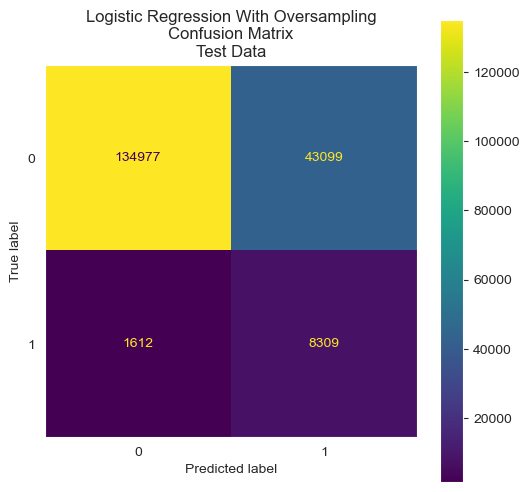

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.99      0.76      0.86    178076
           1       0.16      0.84      0.27      9921

    accuracy                           0.76    187997
   macro avg       0.57      0.80      0.56    187997
weighted avg       0.94      0.76      0.83    187997

Accuracy Score:
Train: 0.809
Test: 0.762 
Precision Score:
Train: 0.839
Test: 0.162 
Recall Score:
Train: 0.843
Test: 0.838 
F1 Score:
Train: 0.841
Test: 0.271 
AUC Score:
Train: 0.888
Test: 0.885 


In [ ]:
###############
# MODEL FITTING #
###############

# Oversampled Data
logit_oversampled = LogisticRegression(max_iter=1000, random_state=42)
logit_oversampled.fit(X_train_scaled_oversampled, y_train_oversampled)

# Hard Predictions for train and test data
y_pred_train = logit_oversampled.predict(X_train_scaled_oversampled)
y_pred_test = logit_oversampled.predict(X_test_scaled_oversampled)

# Calculate predicted probabilities for train and test
y_pred_proba_train = logit_oversampled.predict_proba(X_train_scaled_oversampled)[:, 1]
y_pred_proba_test = logit_oversampled.predict_proba(X_test_scaled_oversampled)[:, 1]


##################
# MODEL EVALUATION #
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(logit_oversampled, X_test_scaled_oversampled, y_test)
plt.title('Logistic Regression With Oversampling\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test)
print('Test Data classification report: ', print_line, report_original)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_oversampled, y_pred_train):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_oversampled, y_pred_train):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_oversampled, y_pred_train):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_oversampled, y_pred_train):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_oversampled, y_pred_proba_train):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

- While the model shows an improvement in the Recall score compared to other methods, it exhibits signs of overfitting, as evidenced by a notably lower accuracy score on the test set relative to the training accuracy. Consequently, oversampling does not appear to be an effective method for enhancing model performance.

---

### 5.5 Best Model Without Scaling - Logistic Regression With Upsampling (without Scaling and PCA) <a class="anchor" id="5e"></a>


In this section, I will evaluate the best-performing model (logistic regression with upsampling) without scaling to compare how performance varies with and without scaling.

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

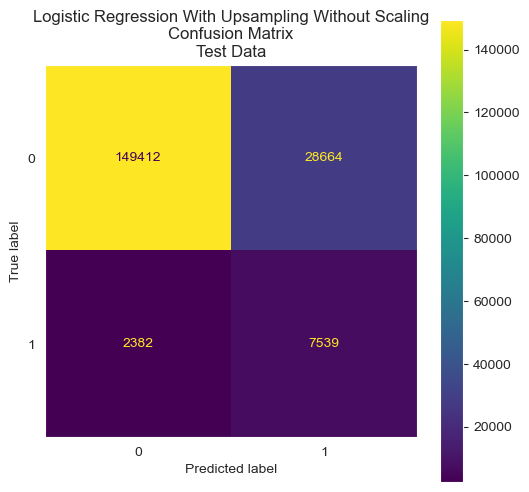

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.84      0.91    178076
           1       0.21      0.76      0.33      9921

    accuracy                           0.83    187997
   macro avg       0.60      0.80      0.62    187997
weighted avg       0.94      0.83      0.88    187997

Accuracy Score:
Train: 0.801
Test: 0.835 
Precision Score:
Train: 0.826
Test: 0.208 
Recall Score:
Train: 0.763
Test: 0.760 
F1 Score:
Train: 0.794
Test: 0.327 
AUC Score:
Train: 0.887
Test: 0.884 


In [ ]:
###############
#MODEL FITTING#
###############

# Upsampled Data without scaling
logit_upsampled = LogisticRegression(max_iter=1000, random_state=42)
logit_upsampled.fit(X_train_upsampled, y_train_upsampled)

# Hard Predictions for train and test data
y_pred_train = logit_upsampled.predict(X_train_upsampled)
y_pred_test = logit_upsampled.predict(X_test)

# Predicted probabilities for train and test data
y_pred_proba_train = logit_upsampled.predict_proba(X_train_upsampled)[:, 1]
y_pred_proba_test = logit_upsampled.predict_proba(X_test)[:, 1]


##################
#Model Evaluation#
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(logit_upsampled, X_test, y_test)
plt.title('Logistic Regression With Upsampling Without Scaling\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test)
print('Test Data classification report: ', print_line, report_original)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_upsampled,y_pred_train):.3f}')
print(f'Test: {accuracy_score(y_test,y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_upsampled, y_pred_train):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_upsampled, y_pred_train):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_upsampled, y_pred_train):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_upsampled, y_pred_proba_train):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

- The model without scaling performs similarly to the model with upsampling and scaling, as the accuracy, precision, recall, F1 score, and AUC metrics are all comparably close. However, it is important to note that the runtime without scaling is significantly slower.

---

#### Model Interpretation

- In logistic regression, a feature with the greatest positive coefficient has the most predictive power for predicting the positive class, while a feature with a significant negative coefficient indicates a greater likelihood of predicting the negative class.
- In this section, I will interpret the top 20 features that have the greatest predictive power for experiencing a heart attack (Class 1), as well as the top 20 features for not experiencing a heart attack (Class 0). Specifically, I will:

    1. Generate a sorted list of the 20 features with their coefficients, ordered from highest to lowest.
    2. Generate a sorted list of the 20 features with their coefficients (negative numbers), ordered from lowest to highest.
    3. Visualize the top 20 features from each list.

In [ ]:
# Fetch the coefficients and corresponding feature name
logit_upsampled_coefficients = pd.Series(logit_upsampled.coef_[0], index=X_train_encoded.columns)

In [ ]:
# Find the top 20 and bottom 20 features that predicting a heart attack
top20_coef = logit_upsampled_coefficients.sort_values(ascending=False).head(20)
bottom20_coef = logit_upsampled_coefficients.sort_values().head(20)

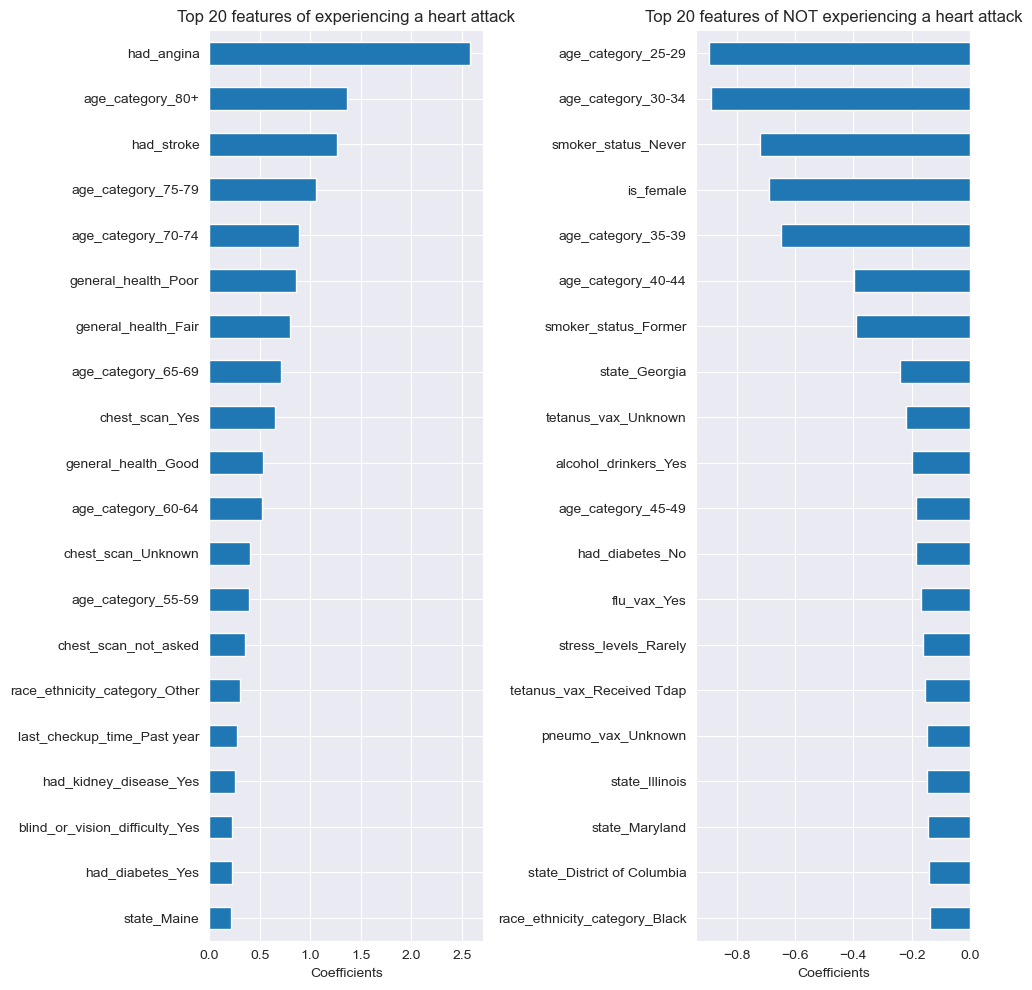

In [ ]:
# Instantiate a subplot
fig, axes = plt.subplots(1, 2 , figsize=(10, 10))

# Create the plot of 20 largest coefficients
top20_coef.sort_values().plot(kind='barh', legend=False, ax=axes[0])
axes[0].set_title('Top 20 features of experiencing a heart attack')
axes[0].set_xlabel('Coefficients')


# Create the plot of 20 smallest coefficients
bottom20_coef.sort_values(ascending=False).plot(kind='barh', legend=False, ax=axes[1])
axes[1].set_title('Top 20 features of NOT experiencing a heart attack')
axes[1].set_xlabel('Coefficients')

plt.tight_layout()
plt.show()

In [ ]:
# get the largest positive coefficient, and calculate the odds
print(f'Top predictive feature of positive instance: {top20_coef.index[0]}')
print(f'Coefficient: {top20_coef.values[0]}')
print(f'Odds: {np.exp(top20_coef.values[0]):.2f}')

Top predictive feature of positive instance: had_angina
Coefficient: 2.581173616765708
Odds: 13.21


In [ ]:
# get the smallest negative coefficient, and calculate the odds
print(f'Top predictive feature of negative instance: {bottom20_coef.index[0]}')
print(f'Coefficient: {bottom20_coef.values[0]}')
print(f'Odds: {np.exp(bottom20_coef.values[0]):.2f}')

Top predictive feature of negative instance: age_category_25-29
Coefficient: -0.892898365919076
Odds: 0.41


In [ ]:
# Create a list of important features from Logistic Regression Model
logreg_important_features = top20_coef.index.tolist() + bottom20_coef.index.tolist()

**Coefficient Interpretation:**<br>
Top predictive word in having a heart attack and not having a heart attack:
| Parameter                   | Coefficient   | Calculation     | Result | Interpretation                                                                 |
|:----------------------------|:--------------|:----------------|:-------|:------------------------------------------------------------------------------|
| **had_angina**    | 2.58         | $e^{2.58}$   | 13.21  | When an individual experienced angina, the odds of the `had_heart_attack` is positive increases by a factor of 13.01. |
| **age_category_25-29**    | -0.89      | $e^{-0.89}$   | 0.41  | If an individual's age is within the range of 25-29, the odds of the `had_heart_attack` is positive decreases by a factor of 0.41.  |


---

### 5.6 Best Model with PCA - Logistic Regression With Upsampling and PCA <a class="anchor" id="5f"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

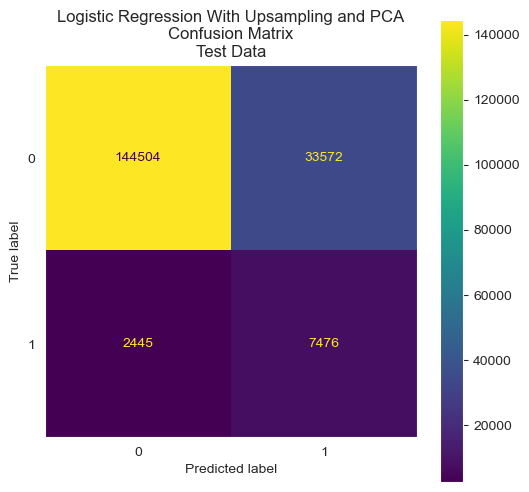

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.81      0.89    178076
           1       0.18      0.75      0.29      9921

    accuracy                           0.81    187997
   macro avg       0.58      0.78      0.59    187997
weighted avg       0.94      0.81      0.86    187997

Accuracy Score:
Train: 0.786
Test: 0.808 
Precision Score:
Train: 0.802
Test: 0.182 
Recall Score:
Train: 0.761
Test: 0.754 
F1 Score:
Train: 0.781
Test: 0.293 
AUC Score:
Train: 0.863
Test: 0.860 


In [ ]:
###############
#MODEL FITTING#
###############

# Upsampling Logistic Regression with PCA
logit_upsampled = LogisticRegression(max_iter=1000, random_state=42)
logit_upsampled.fit(X_train_pca_upsampled, y_train_upsampled)

# Hard Predictions for train and test data
y_pred_train = logit_upsampled.predict(X_train_pca_upsampled)
y_pred_test = logit_upsampled.predict(X_test_pca_upsampled)

# Calculate predicted probabilities for train and test
y_pred_proba_train = logit_upsampled.predict_proba(X_train_pca_upsampled)[:, 1]
y_pred_proba_test = logit_upsampled.predict_proba(X_test_pca_upsampled)[:, 1]

##################
#Model Evaluation#
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(logit_upsampled, X_test_pca_upsampled, y_test)
plt.title('Logistic Regression With Upsampling and PCA\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test)
print('Test Data classification report: ', print_line, report_original)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_upsampled,y_pred_train):.3f}')
print(f'Test: {accuracy_score(y_test,y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_upsampled, y_pred_train):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_upsampled, y_pred_train):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_upsampled, y_pred_train):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_upsampled, y_pred_proba_train):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

### 4.7 Logistic Regression Baseline Modeling Summary <a class="anchor" id="5g"></a>

**Metrics using test data:**
| Model                   | Scaled | PCA | Accuracy | Precision | Recall | F1 Score | AUC   | Notes                       |
|-------------------------|--------|-----|----------|-----------|--------|----------|-------|-----------------------------|
| Logistic Regression      | Yes    | No  | 0.950    | 0.565     | 0.246  | 0.343    | 0.884 | Imbalanced                  |
| Logistic Regression      | Yes    | No  | 0.834    | 0.207    | 0.760  | 0.325    | 0.884 | Downsampled                 |
| Logistic Regression      | Yes    | No  | 0.789    | 0.176     | 0.814  | 0.290    | 0.885 | Oversampled(60% Class 1), Overfitting detected             |
| **Logistic Regression**     | **Yes**    | **No**  | 0.832    | 0.206     | 0.763  | 0.325    | 0.885 | **Upsampled**, Overfitting                   |
| Logistic Regression      | No    | No  | 0.835    | 0.208     | 0.760  | 0.327    | 0.884  | Upsampled, runtime significantly slower                   |
| Logistic Regression      | Yes    | Yes  | 0.808    | 0.182     | 0.754   | 0.293    | 0.860 | Upsampled, pca set at n_components=0.9              |



- By far, hyperparameter tuning has not been performed on any of the Logistic Regression models. The models utilizing upsampling and downsampling demonstrate very similar performance, with the upsampling model achieving slightly better recall metrics.
- All models with upsampling, downsampling, and oversampling exhibit signs of overfitting, where the precision and F1 Score on the test data significanly underperforms compared to the scores on the train data, so feature selection should be performed later to improve generalization.

- I applied oversampling to increase the number of Class 1 (heart attack) observations, resulting in Class 1 comprising 60% of the labels in the training set. While the model showed an improvement in the Recall score, this came at the expense of Precision and F1 Score. Furthermore, the overfitting issue deteriorated, as evidenced by a noticeable gap between the accuracy on the training data and the accuracy on the test data.

- After determining that the upsampling model was the best performer, I decided to experiment with it without scaling, as well as with both scaling and PCA.

- The model without scaling yielded very similar performance metrics but exhibited significantly slower runtime. This similarity may be attributed to the fact that most of the features are binary, resulting in subtle differences in scale across features. Additionally, since many features are normally distributed, scaling does not provide substantial benefits.

- The model with PCA performed worse than the best performer, suggesting that the features may contain important non-linear relationships that PCA fails to capture. Consequently, valuable information may have been lost during the dimensionality reduction process.

---

## 6 Baseline Modeling - Naive Bayes  <a class="anchor" id="6"></a>

### 6.1 Naive Bayes With Imbalanced Class (with class imbalance and scaling, without PCA) <a class="anchor" id="6a"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

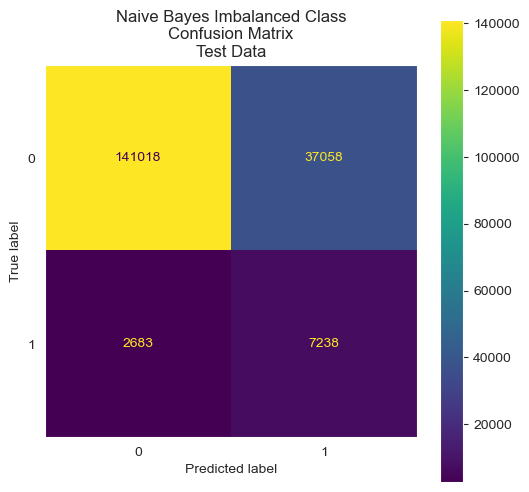

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.79      0.88    178076
           1       0.16      0.73      0.27      9921

    accuracy                           0.79    187997
   macro avg       0.57      0.76      0.57    187997
weighted avg       0.94      0.79      0.84    187997

Accuracy Score:
Train: 0.788
Test: 0.789 
Precision Score:
Train: 0.163
Test: 0.163 
Recall Score:
Train: 0.733
Test: 0.730 
F1 Score:
Train: 0.267
Test: 0.267 
AUC Score:
Train: 0.826
Test: 0.824 


In [ ]:
###############
#MODEL FITTING#
###############

# Imbalanced Data
nbmodel_imbalanced = GaussianNB()
nbmodel_imbalanced.fit(X_train_scaled, y_train)

# Hard Predictions for train and test data
y_pred_train = nbmodel_imbalanced.predict(X_train_scaled)
y_pred_test = nbmodel_imbalanced.predict(X_test_scaled)


# Predicted probabilities for train and test data
y_pred_proba_train = nbmodel_imbalanced.predict_proba(X_train_scaled)[:, 1]
y_pred_proba_test = nbmodel_imbalanced.predict_proba(X_test_scaled)[:, 1]


##################
#Model Evaluation#
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(nbmodel_imbalanced, X_test_scaled, y_test)
plt.title('Naive Bayes Imbalanced Class\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test)
print('Test Data classification report: ', print_line, report_original)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train, y_pred_train):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train, y_pred_train):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train, y_pred_train):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train, y_pred_train):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train, y_pred_proba_train):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

### 6.2 Naive Bayes With Upsampling (scaled, without PCA) <a class="anchor" id="6b"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

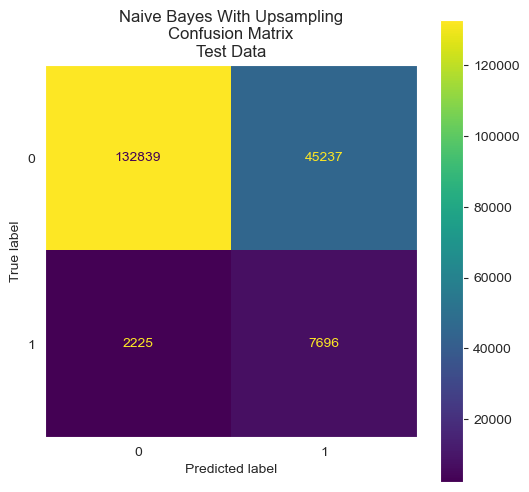

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.75      0.85    178076
           1       0.15      0.78      0.24      9921

    accuracy                           0.75    187997
   macro avg       0.56      0.76      0.55    187997
weighted avg       0.94      0.75      0.82    187997

Accuracy Score:
Train: 0.762
Test: 0.748 
Precision Score:
Train: 0.754
Test: 0.145 
Recall Score:
Train: 0.778
Test: 0.776 
F1 Score:
Train: 0.766
Test: 0.245 
AUC Score:
Train: 0.826
Test: 0.824 


In [ ]:
###############
#MODEL FITTING#
###############

# Upsampled Data
nbmodel_upsampled = GaussianNB()
nbmodel_upsampled.fit(X_train_scaled_upsampled, y_train_upsampled)

# Hard Predictions for train and test data
y_pred_train = nbmodel_upsampled.predict(X_train_scaled_upsampled)
y_pred_test = nbmodel_upsampled.predict(X_test_scaled_upsampled)

# Calculate predicted probabilities for train and test
y_pred_proba_train = nbmodel_upsampled.predict_proba(X_train_scaled_upsampled)[:, 1]
y_pred_proba_test = nbmodel_upsampled.predict_proba(X_test_scaled_upsampled)[:, 1]

##################
#Model Evaluation#
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(nbmodel_upsampled, X_test_scaled_upsampled, y_test)
plt.title('Naive Bayes With Upsampling\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test)
print('Test Data classification report: ', print_line, report_original)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_upsampled,y_pred_train):.3f}')
print(f'Test: {accuracy_score(y_test,y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_upsampled, y_pred_train):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_upsampled, y_pred_train):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_upsampled, y_pred_train):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_upsampled, y_pred_proba_train):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

#### 6.3 Naive Bayes With Downsampling (scaled, without PCA) <a class="anchor" id="6c"></a>

Confusion Matrix: 


<Figure size 300x300 with 0 Axes>

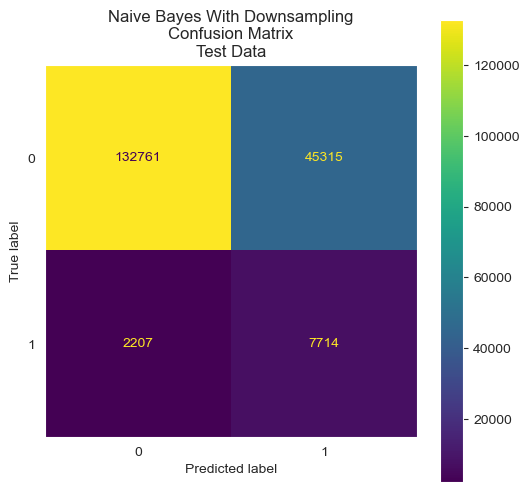

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.98      0.75      0.85    178076
           1       0.15      0.78      0.25      9921

    accuracy                           0.75    187997
   macro avg       0.56      0.76      0.55    187997
weighted avg       0.94      0.75      0.82    187997

Accuracy Score:
Train: 0.761
Test: 0.747 
Precision Score:
Train: 0.752
Test: 0.145 
Recall Score:
Train: 0.779
Test: 0.778 
F1 Score:
Train: 0.765
Test: 0.245 
AUC Score:
Train: 0.826
Test: 0.824 


In [ ]:
###############
# MODEL FITTING #
###############

# Instantiate and fit Gaussian Naive Bayes on Downsampled Data
nbmodel_downsampled = GaussianNB()
nbmodel_downsampled.fit(X_train_scaled_downsampled, y_train_downsampled)

# Hard Predictions for train and test data
y_pred_train = nbmodel_downsampled.predict(X_train_scaled_downsampled)
y_pred_test = nbmodel_downsampled.predict(X_test_scaled_downsampled)

# Predicted probabilities for train and test data
y_pred_proba_train = nbmodel_downsampled.predict_proba(X_train_scaled_downsampled)[:, 1]
y_pred_proba_test = nbmodel_downsampled.predict_proba(X_test_scaled_downsampled)[:, 1]

##################
# MODEL EVALUATION #
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion Matrix:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(nbmodel_downsampled, X_test_scaled_downsampled, y_test)
plt.title('Naive Bayes With Downsampling\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Report
report_original = classification_report(y_test, y_pred_test)
print('Test Data Classification Report:', print_line, report_original)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_downsampled, y_pred_train):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_downsampled, y_pred_train):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_downsampled, y_pred_train):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_downsampled, y_pred_train):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_downsampled, y_pred_proba_train):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

### 6.4 Naive Bayes Baseline Modeling Summary <a class="anchor" id="6d"></a>

**Metrics using test data:**
| Model                   | Scaled | PCA | Accuracy | Precision | Recall | F1 Score | AUC   | Notes                       |
|-------------------------|--------|-----|----------|-----------|--------|----------|-------|-----------------------------|
| Naive Bayes    | Yes  | No  | 0.789    | 0.163     | 0.730 | 0.267   | 0.824  |Imbalanced                 |
| Naive Bayes | Yes | No  | 0.748    | 0.145     | 0.776  | 0.245    | 0.824 | Upsampled, Overfitting  |
| **Naive Bayes**  | **Yes**    | **No**  | 0.747    | 0.145     | 0.778  | 0.245    | 0.824 | **Downsampled**, Overfitting  |

- By far, hyperparameter tuning has not been performed on any of the Naive Bayes models. The models utilizing upsampling and downsampling demonstrate very similar performance, with the downsampling model achieving slightly better Recall metrics.
- Both models with upsampling and downsampling exhibit sign of overfitting, where the Precision and F1 Score on the test data significantly underperforms compared to the scores on the train data, so feature selection should be performed later to improve generalization.
- Compared to the imbalanced Logistic Regression model, the Naive Bayes model demonstrates a significantly higher Recall score at the expense of Accuracy and Precision. This can be attributed to the fundamental nature of Naive Bayes, which calculates probabilities based on class distributions, allowing for better identification of the minority class in the context of an imbalanced distribution.
- The  best-performing Naive Bayes model exhibits a substantially low Precision score, indicating that many alerts for potential heart attacks triggered by the model are false positives.


---



## 7 Baseline Modeling - Decision Tree  <a class="anchor" id="7"></a>

### 7.1 Decision Tree Imbalanced (with class imbalance and scaling, without PCA) <a class="anchor" id="7a"></a>

Confusion Matrix: 


<Figure size 300x300 with 0 Axes>

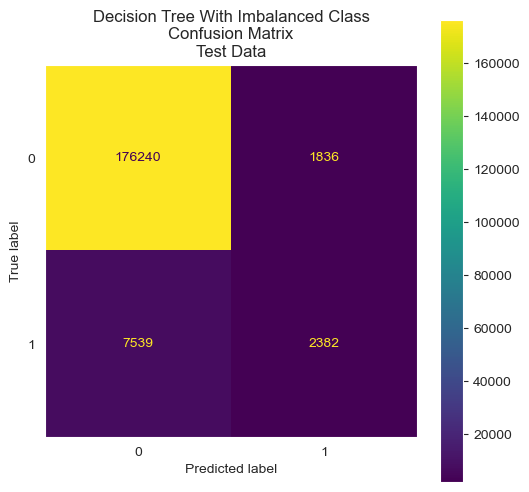

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.96      0.99      0.97    178076
           1       0.56      0.24      0.34      9921

    accuracy                           0.95    187997
   macro avg       0.76      0.61      0.66    187997
weighted avg       0.94      0.95      0.94    187997

Accuracy Score:
Train: 0.951
Test: 0.950 
Precision Score:
Train: 0.589
Test: 0.565 
Recall Score:
Train: 0.246
Test: 0.240 
F1 Score:
Train: 0.347
Test: 0.337 
AUC Score:
Train: 0.859
Test: 0.855 


In [ ]:
###############
# MODEL FITTING #
###############

# Fit Decision Tree Classifier on Imbalanced Data
dt_imbalanced = DecisionTreeClassifier(max_depth=7, random_state=42)
dt_imbalanced.fit(X_train_scaled, y_train)  # Using the original scaled data

# Hard Predictions for train and test data
y_pred_train = dt_imbalanced.predict(X_train_scaled)
y_pred_test = dt_imbalanced.predict(X_test_scaled)

# Predicted probabilities for train and test data
y_pred_proba_train = dt_imbalanced.predict_proba(X_train_scaled)[:, 1]
y_pred_proba_test = dt_imbalanced.predict_proba(X_test_scaled)[:, 1]

##################
# MODEL EVALUATION #
##################

print_line = "\n" + "===========" * 6

# Display Confusion Matrix
print('Confusion Matrix:', print_line)
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(dt_imbalanced, X_test_scaled, y_test)
plt.title('Decision Tree With Imbalanced Class\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Report
report_original = classification_report(y_test, y_pred_test)
print('Test Data Classification Report:', print_line, report_original)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train, y_pred_train):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train, y_pred_train):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train, y_pred_train):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train, y_pred_train):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train, y_pred_proba_train):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

### 7.2 Decision Tree With Upsampling (scaled, without PCA) <a class="anchor" id="7b"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

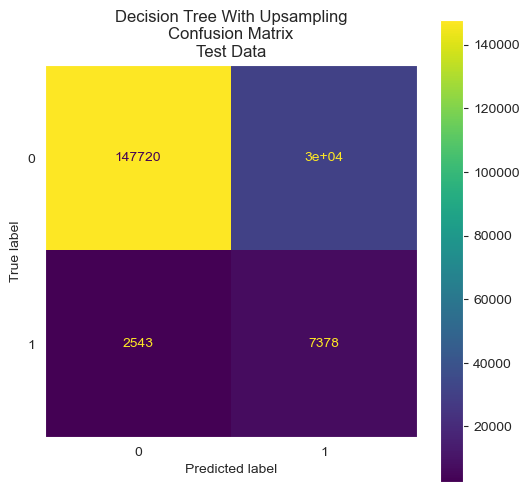

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.83      0.90    178076
           1       0.20      0.74      0.31      9921

    accuracy                           0.83    187997
   macro avg       0.59      0.79      0.60    187997
weighted avg       0.94      0.83      0.87    187997

Accuracy Score:
Train: 0.791
Test: 0.825 
Precision Score:
Train: 0.816
Test: 0.196 
Recall Score:
Train: 0.753
Test: 0.744 
F1 Score:
Train: 0.783
Test: 0.310 
AUC Score:
Train: 0.862
Test: 0.856 


In [ ]:
###############
#MODEL FITTING#
###############

# Upsampled Data
dt_upsampled = DecisionTreeClassifier(max_depth=7, random_state=42)
dt_upsampled.fit(X_train_scaled_upsampled, y_train_upsampled)

# Hard Predictions for train and test data
y_pred_train = dt_upsampled.predict(X_train_scaled_upsampled)
y_pred_test = dt_upsampled.predict(X_test_scaled_upsampled)

# Predicted probabilities for train and test data
y_pred_proba_train = dt_upsampled.predict_proba(X_train_scaled_upsampled)[:, 1]
y_pred_proba_test = dt_upsampled.predict_proba(X_test_scaled_upsampled)[:, 1]

##################
#Model Evaluation#
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(dt_upsampled, X_test_scaled_upsampled, y_test)
plt.title('Decision Tree With Upsampling\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test)
print('Test Data classification report: ', print_line, report_original)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_upsampled,y_pred_train):.3f}')
print(f'Test: {accuracy_score(y_test,y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_upsampled, y_pred_train):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_upsampled, y_pred_train):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_upsampled, y_pred_train):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_upsampled, y_pred_proba_train):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

### 7.3 Decision Tree With Downsampling (scaled, without PCA) <a class="anchor" id="7c"></a>

Confusion Matrix: 


<Figure size 300x300 with 0 Axes>

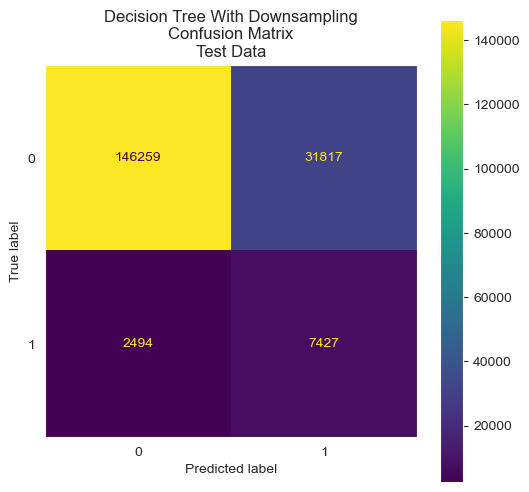

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.98      0.82      0.90    178076
           1       0.19      0.75      0.30      9921

    accuracy                           0.82    187997
   macro avg       0.59      0.78      0.60    187997
weighted avg       0.94      0.82      0.86    187997

Accuracy Score:
Train: 0.792
Test: 0.817 
Precision Score:
Train: 0.814
Test: 0.189 
Recall Score:
Train: 0.756
Test: 0.749 
F1 Score:
Train: 0.784
Test: 0.302 
AUC Score:
Train: 0.863
Test: 0.854 


In [ ]:
###############
# MODEL FITTING #
###############

# Downsampled Data
dt_downsampled = DecisionTreeClassifier(max_depth=7, random_state=42)
dt_downsampled.fit(X_train_scaled_downsampled, y_train_downsampled)

# Hard Predictions for train and test data
y_pred_train = dt_downsampled.predict(X_train_scaled_downsampled)
y_pred_test = dt_downsampled.predict(X_test_scaled_downsampled)

# Predicted probabilities for train and test data
y_pred_proba_train = dt_downsampled.predict_proba(X_train_scaled_downsampled)[:, 1]
y_pred_proba_test = dt_downsampled.predict_proba(X_test_scaled_downsampled)[:, 1]

##################
# MODEL EVALUATION #
##################

print_line = "\n" + "===========" * 6

# Display Confusion Matrix
print('Confusion Matrix:', print_line)
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(dt_downsampled, X_test_scaled_downsampled, y_test)
plt.title('Decision Tree With Downsampling\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Report
report_original = classification_report(y_test, y_pred_test)
print('Test Data Classification Report:', print_line, report_original)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_downsampled, y_pred_train):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_downsampled, y_pred_train):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_downsampled, y_pred_train):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_downsampled, y_pred_train):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_downsampled, y_pred_proba_train):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

#### Model Interpretation

The Decision model includes a feature importance metric that measures how much each feature contributes to the model's predictions. Features with higher importance scores are considered more impactful within the model. In this section, I will:
1. Find the top 30 features with the highest importance scores.
2. Visualize the most influential features.

In [416]:
# Get feature importances
dt_importances = dt_downsampled.feature_importances_

# Create a DataFrame with features and Feature importances
dt_feature_importance_df = pd.DataFrame(
    dt_importances.reshape(-1, 1),
    index=X_train_downsampled.columns,
    columns=['feature_importance']
)

# Sort by the feature importance and show the top five rows
dt_feature_importance_df = dt_feature_importance_df.sort_values(by='feature_importance', ascending=False)
dt_feature_importance_df.head(5)

,feature_importance
had_angina,0.656818
difficulty_walking_Yes,0.111885
had_stroke,0.077401
had_diabetes_Yes,0.043222
age_category_80+,0.035304


<Figure size 1500x1500 with 0 Axes>

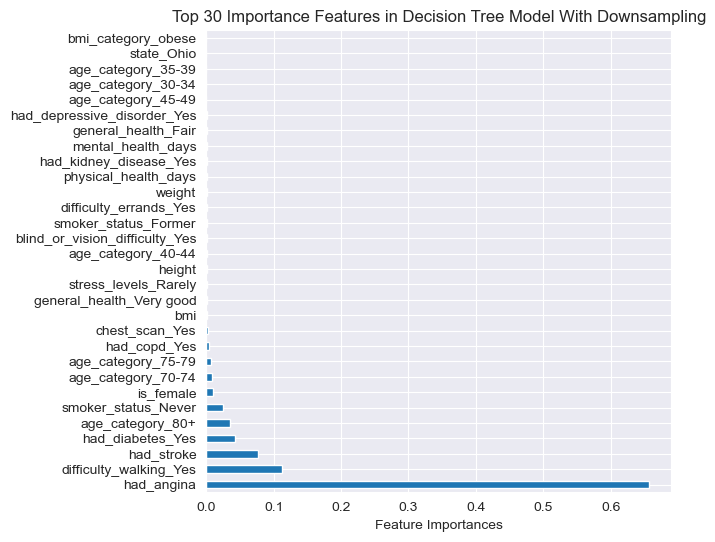

In [424]:
# Visualize the top 40 important features
plt.figure(figsize=(15, 15))
dt_feature_importance_df.head(30).plot(kind='barh', legend=False)
plt.title('Top 30 Importance Features in Decision Tree Model With Downsampling')
plt.xlabel('Feature Importances')

plt.show()

In [431]:
# Create a list of 11 important features in Decision Tree
dt_important_features = dt_feature_importance_df.head(11).index.tolist()

dt_important_features

['had_angina',
 'difficulty_walking_Yes',
 'had_stroke',
 'had_diabetes_Yes',
 'age_category_80+',
 'smoker_status_Never',
 'is_female',
 'age_category_70-74',
 'age_category_75-79',
 'had_copd_Yes',
 'chest_scan_Yes']

**Takeaways**:
- In the Decision Tree model, only 11 out of 149 features (ranging from `chest_scan_yes` to `had_angina`) were found to significantly contribute to predicting the risk of experiencing a heart attack. This indicates that a vast number of features were deemed unimportant, potentially leading to overfitting. 
- The presence of many irrelevant features likely contributes to the significant gap between the precision and F1 scores on the training and test datasets. Reducing or refining the feature set could help mitigate this issue and improve model generalization.
---

### 7.4 Best Model with PCA - Decision Tree With Downsampling and PCA <a class="anchor" id="7d"></a>

Confusion Matrix: 


<Figure size 300x300 with 0 Axes>

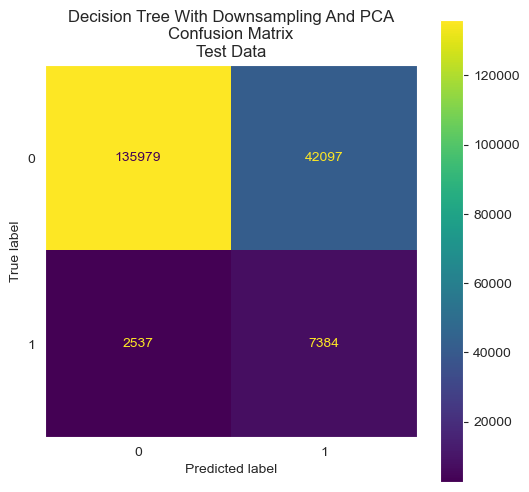

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.98      0.76      0.86    178076
           1       0.15      0.74      0.25      9921

    accuracy                           0.76    187997
   macro avg       0.57      0.75      0.55    187997
weighted avg       0.94      0.76      0.83    187997

Accuracy Score:
Train: 0.772
Test: 0.763 
Precision Score:
Train: 0.777
Test: 0.149 
Recall Score:
Train: 0.764
Test: 0.744 
F1 Score:
Train: 0.770
Test: 0.249 
AUC Score:
Train: 0.847
Test: 0.829 


In [310]:
###############
# MODEL FITTING #
###############

# Fit Decision Tree Classifier on Downsampled Data with PCA
dt_downsampled_pca = DecisionTreeClassifier(max_depth=7, random_state=42)
dt_downsampled_pca.fit(X_train_pca_downsampled, y_train_downsampled)

# Hard Predictions for training and test datasets
y_pred_train = dt_downsampled_pca.predict(X_train_pca_downsampled)
y_pred_test = dt_downsampled_pca.predict(X_test_pca_downsampled)

# Predicted probabilities for training and test datasets
y_pred_proba_train = dt_downsampled_pca.predict_proba(X_train_pca_downsampled)[:, 1]
y_pred_proba_test = dt_downsampled_pca.predict_proba(X_test_pca_downsampled)[:, 1]

##################
# MODEL EVALUATION #
##################

print_line = "\n" + "===========" * 6

# Display Confusion Matrix
print('Confusion Matrix:', print_line)

plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(dt_downsampled_pca, X_test_pca_downsampled, y_test)
plt.title('Decision Tree With Downsampling And PCA\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Report
report_original = classification_report(y_test, y_pred_test)
print('Test Data Classification Report:', print_line, report_original)

# Calculate and print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_downsampled, y_pred_train):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Calculate and print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_downsampled, y_pred_train):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Calculate and print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_downsampled, y_pred_train):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Calculate and print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_downsampled, y_pred_train):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_downsampled, y_pred_proba_train):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

### 7.5 Decision Tree Baseline Modeling Summary <a class="anchor" id="7e"></a>

**Metrics using test data:**<br>
All Models uses hyperparameters: max_depth=7 
| Model                   | Scaled | PCA | Accuracy | Precision | Recall | F1 Score | AUC   | Notes                       |
|-------------------------|--------|-----|----------|-----------|--------|----------|-------|-----------------------------|
| Decision Tree    | Yes  | No  | 0.950| 0.565 | 0.240 | 0.337  | 0.855 |Imbalanced   |      
| Decision Tree | Yes | No  | 0.825    | 0.196  |0.744 | 0.310  |0.856 | Upsampled, overfitting  |
| **Decision Tree**  | **Yes**    | **No**  | 0.817  |0.189  | 0.749 |0.302  |0.854 | **Downsampled**, overfitting    |
| Decision Tree | Yes| Yes | 0.763  |0.149 | 0.744  |0.249  |0.829| Downsampled with PCA, overfitting  |

- So far, hyperparameter tuning has not been conducted on any of the Naive Bayes models. Due to the tendency of Decision Trees to overfit the data, I have set the maximum depth to 7 across all baseline models. The models utilizing both upsampling and downsampling exhibit very similar performance, with the downsampling model achieving slightly better recall metrics.
- All models with upsampling and downsampling exhibit sign of overfitting, where the precision and F1 Score on the test data significantly underperforms compared to the scores on the train data, so feature selection should be performed later to improve generalization.
- In the model interpretation of Decision Tree Model With Downsampling model, only 11 out of 149 features were found to significantly contribute to predicting the target. A vast number of unimportant features could potentially lead to overfitting, so reducing the feature could help improve generalization.

---




## 8 Baseline Modeling - Random Forest  <a class="anchor" id="8"></a>

### 8.1 Random Forest Imbalanced (with class imbalance and scaling, without PCA) <a class="anchor" id="8a"></a>

Confusion Matrix: 


<Figure size 300x300 with 0 Axes>

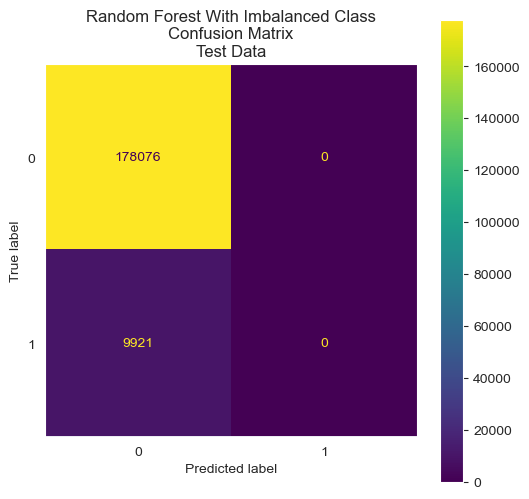

c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.95      1.00      0.97    178076
           1       0.00      0.00      0.00      9921

    accuracy                           0.95    187997
   macro avg       0.47      0.50      0.49    187997
weighted avg       0.90      0.95      0.92    187997

Accuracy Score:
Train: 0.947
Test: 0.947 
Precision Score:
Train: 1.000
Test: 0.000 
Recall Score:


c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train: 0.000
Test: 0.000 
F1 Score:
Train: 0.000
Test: 0.000 
AUC Score:
Train: 0.878
Test: 0.873 


In [311]:
###############
# MODEL FITTING #
###############

# Fit Random Forest Classifier on Imbalanced Data
rf_imbalanced = RandomForestClassifier(n_estimators=50, max_depth=7, random_state=42)
rf_imbalanced.fit(X_train_scaled, y_train)  

# Hard Predictions for train and test data
y_pred_train = rf_imbalanced.predict(X_train_scaled)
y_pred_test = rf_imbalanced.predict(X_test_scaled)

# Predicted probabilities for train and test data
y_pred_proba_train = rf_imbalanced.predict_proba(X_train_scaled)[:, 1]
y_pred_proba_test = rf_imbalanced.predict_proba(X_test_scaled)[:, 1]

##################
# MODEL EVALUATION #
##################

print_line = "\n" + "===========" * 6

# Display Confusion Matrix
print('Confusion Matrix:', print_line)
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(rf_imbalanced, X_test_scaled, y_test)
plt.title('Random Forest With Imbalanced Class\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Report
report_original = classification_report(y_test, y_pred_test)
print('Test Data Classification Report:', print_line, report_original)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train, y_pred_train):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train, y_pred_train):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train, y_pred_train):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train, y_pred_train):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train, y_pred_proba_train):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

### 8.2 Random Forest With Upsampling (scaled, without PCA) <a class="anchor" id="8b"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

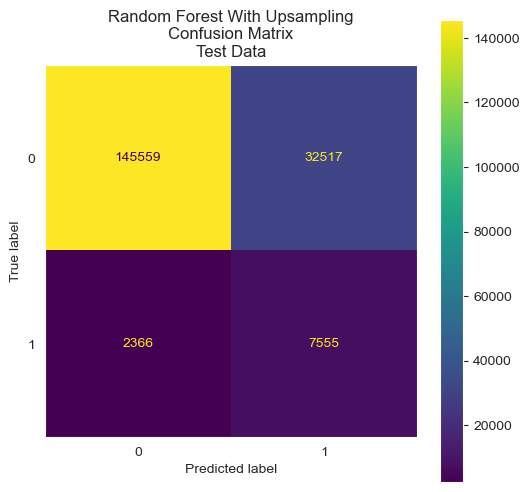

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.82      0.89    178076
           1       0.19      0.76      0.30      9921

    accuracy                           0.81    187997
   macro avg       0.59      0.79      0.60    187997
weighted avg       0.94      0.81      0.86    187997

Accuracy Score:
Train: 0.793
Test: 0.814 
Precision Score:
Train: 0.808
Test: 0.189 
Recall Score:
Train: 0.768
Test: 0.762 
F1 Score:
Train: 0.787
Test: 0.302 
AUC Score:
Train: 0.876
Test: 0.871 


In [312]:
###############
#MODEL FITTING#
###############

# Upsampled Data
rf_upsampled = RandomForestClassifier(n_estimators=50, max_depth=7, random_state=42)
rf_upsampled.fit(X_train_scaled_upsampled, y_train_upsampled)  

# Hard Predictions for train and test data
y_pred_train = rf_upsampled.predict(X_train_scaled_upsampled)
y_pred_test = rf_upsampled.predict(X_test_scaled_upsampled)

# Predicted probabilities for train and test data
y_pred_proba_train = rf_upsampled.predict_proba(X_train_scaled_upsampled)[:, 1]
y_pred_proba_test = rf_upsampled.predict_proba(X_test_scaled_upsampled)[:, 1]

##################
#Model Evaluation#
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(rf_upsampled, X_test_scaled_upsampled, y_test)
plt.title('Random Forest With Upsampling\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test)
print('Test Data classification report: ', print_line, report_original)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_upsampled,y_pred_train):.3f}')
print(f'Test: {accuracy_score(y_test,y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_upsampled, y_pred_train):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_upsampled, y_pred_train):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_upsampled, y_pred_train):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_upsampled, y_pred_proba_train):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

#### Model Interpretation

The Random Forest model includes a feature importance metric that measures how much each feature contributes to the model's predictions. Features with higher importance scores are considered more impactful within the model. In this section, I will:
1. Find the top 30 features with the highest importance scores.
2. Visualize the most influential features.

In [379]:
# Retrieve the feature importances from Random Forest with upsampling model
rf_importances = rf_upsampled.feature_importances_

# Create a DataFrame of each feature and its importance in Random Forest Model
rf_feature_importance_df = pd.DataFrame(rf_importances.reshape(-1, 1), 
                                     index= X_train_upsampled.columns,
                                     columns=['feature_importance'])

# Sort the feature importance DataFramce and show top five rows
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='feature_importance', ascending=False)

rf_feature_importance_df.head()

,feature_importance
had_angina,0.339515
had_stroke,0.067530
pneumo_vax_Yes,0.063429
difficulty_walking_Yes,0.060329
had_diabetes_Yes,0.053448


<Figure size 1500x1500 with 0 Axes>

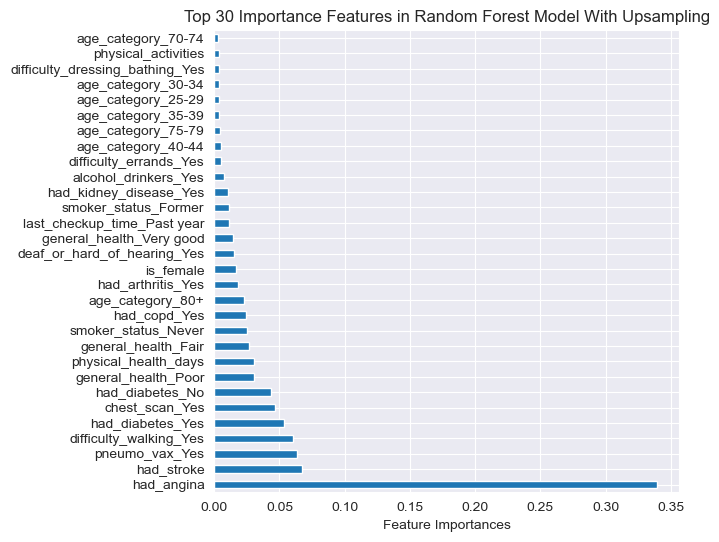

In [373]:
# Visualize the top 40 important features
plt.figure(figsize=(15, 15))
rf_feature_importance_df.head(30).plot(kind='barh', legend=False)
plt.title('Top 30 Importance Features in Random Forest Model With Upsampling')
plt.xlabel('Feature Importances')

plt.show()

In [433]:
# Create a list of important features from Random Forest
rf_important_features = rf_feature_importance_df.head(30).index.tolist()

rf_important_features


['had_angina',
 'had_stroke',
 'pneumo_vax_Yes',
 'difficulty_walking_Yes',
 'had_diabetes_Yes',
 'chest_scan_Yes',
 'had_diabetes_No',
 'general_health_Poor',
 'physical_health_days',
 'general_health_Fair',
 'smoker_status_Never',
 'had_copd_Yes',
 'age_category_80+',
 'had_arthritis_Yes',
 'is_female',
 'deaf_or_hard_of_hearing_Yes',
 'general_health_Very good',
 'last_checkup_time_Past year',
 'smoker_status_Former',
 'had_kidney_disease_Yes',
 'alcohol_drinkers_Yes',
 'difficulty_errands_Yes',
 'age_category_40-44',
 'age_category_75-79',
 'age_category_35-39',
 'age_category_25-29',
 'age_category_30-34',
 'difficulty_dressing_bathing_Yes',
 'physical_activities',
 'age_category_70-74']

**Takeaways**:
- Compared to the Decision Tree model, a greater number of features contributed to the prediction of the target variable in the Random Forest model. However, the proportion of important features remains relatively low, as there are clearly fewer than 30 important features out of a total of 149.
- The presence of many irrelevant features likely contributes to the significant gap between the precision and F1 scores on the training and test datasets. Reducing or refining the feature set could help mitigate this issue and improve model generalization.
- By comparing the important features in the Decision Tree and Logistic Regression models, I found that many of the top-ranked important features in the Random Forest model, such as `had_angina`, `difficult_walking_Yes`, `had_stroke`, and `age_category_80+`,etc., are also considered important across the other models. This suggests a consistent identification of key predictors among the different modeling approaches.
---

### 8.3 Random Forest With Downsampling (scaled, without PCA) <a class="anchor" id="8c"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

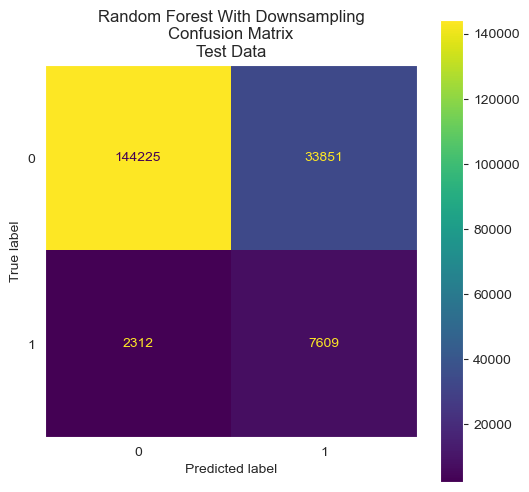

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.81      0.89    178076
           1       0.18      0.77      0.30      9921

    accuracy                           0.81    187997
   macro avg       0.58      0.79      0.59    187997
weighted avg       0.94      0.81      0.86    187997

Accuracy Score:
Train: 0.794
Test: 0.808 
Precision Score:
Train: 0.807
Test: 0.184 
Recall Score:
Train: 0.774
Test: 0.767 
F1 Score:
Train: 0.790
Test: 0.296 
AUC Score:
Train: 0.876
Test: 0.870 


In [498]:
###############
#MODEL FITTING#
###############

# Downsampled Data
rf_downsampled = RandomForestClassifier(n_estimators=50, max_depth=7, random_state=42)
rf_downsampled.fit(X_train_scaled_downsampled, y_train_downsampled)  

# Hard Predictions for train and test data
y_pred_train = rf_downsampled.predict(X_train_scaled_downsampled)
y_pred_test = rf_downsampled.predict(X_test_scaled_downsampled)

# Predicted probabilities for train and test data
y_pred_proba_train = rf_downsampled.predict_proba(X_train_scaled_downsampled)[:, 1]
y_pred_proba_test = rf_downsampled.predict_proba(X_test_scaled_downsampled)[:, 1]

##################
#Model Evaluation#
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(rf_downsampled, X_test_scaled_downsampled, y_test)
plt.title('Random Forest With Downsampling\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test)
print('Test Data classification report: ', print_line, report_original)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_downsampled,y_pred_train):.3f}')
print(f'Test: {accuracy_score(y_test,y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_downsampled, y_pred_train):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_downsampled, y_pred_train):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_downsampled, y_pred_train):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_downsampled, y_pred_proba_train):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---


### 8.4 Random Forest Baseline Modeling Summary  <a class="anchor" id="8d"></a>

**Metrics using test data:**<br>
All Models uses hyperparameters: n_estimators=50, max_depth=7 
| Model                   | Scaled | PCA | Accuracy | Precision | Recall | F1 Score | AUC   | Notes                       |
|-------------------------|--------|-----|----------|-----------|--------|----------|-------|-----------------------------|
| Random Forest    | Yes  | No  | 0.947 | 0.000 | 0.000 | 0.000 | 0.873 |Imbalanced,  |      
| **Random Forest** | **Yes** | **No**  | 0.814|0.189 |0.762|0.302  |0.871  | **Upsampled**, overfitting  |
| Random Forest  |Yes | No | 0.817  |0.189  | 0.749 |0.302  |0.854 | Downsampled,  overfitting |


- So far, hyperparameter tuning has not been conducted on any of the Random Forest models. Due to the tendency of Decision Trees to overfit the data, I have set the maximum depth to 7 across all baseline models. The models utilizing both upsampling and downsampling exhibit very similar performance, with the upampling model achieving slightly better Recall metrics.
- The first Random Forest Model, affected by class imbalance, predicts all negatives, resulting in zero true positives, and consequently, both precision and recall are zero. Despite this, the model achieves a relatively high AUC score, reflecting its ability to distinguish between classes. This suggests that while predictions remain below the default threshold at 0.5, the model assigns higher probabilities to positive instances compared to negative ones.
- All models with upsampling and downsampling exhibit sign of overfitting, where the Precision and F1 Score on the test data significanly underperforms compared to the scores on the train data, so feature selection should be performed later to improve generalization.
- Comparing the important features in the Decision Tree and Logistic Regression models, I found that many top-ranked features in the Random Forest model, such as `had_angina`, `difficult_walking_Yes`, `had_stroke`, and `age_category_80+`, etc., are also recognized as important in the other models. This indicates a consistent identification of key predictors across different approaches.

---




## 9 Baseline Modeling - XGBoost  <a class="anchor" id="9"></a>

### 9.1 XGBoost Imbalanced (with class imbalance and scaling, without PCA) <a class="anchor" id="9a"></a>

Confusion Matrix: 


<Figure size 300x300 with 0 Axes>

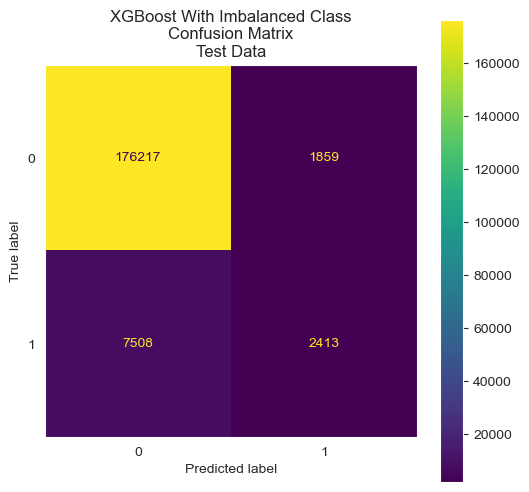

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.96      0.99      0.97    178076
           1       0.56      0.24      0.34      9921

    accuracy                           0.95    187997
   macro avg       0.76      0.62      0.66    187997
weighted avg       0.94      0.95      0.94    187997

Accuracy Score:
Train: 0.956
Test: 0.950 
Precision Score:
Train: 0.687
Test: 0.565 
Recall Score:
Train: 0.293
Test: 0.243 
F1 Score:
Train: 0.411
Test: 0.340 
AUC Score:
Train: 0.908
Test: 0.882 


In [500]:
###############
# MODEL FITTING #
###############

# Fit XGBoost Classifier on Imbalanced Data
xgb_imalanced = XGBClassifier(random_state=42)
xgb_imalanced.fit(X_train_scaled, y_train)  # Using the original scaled data

# Hard Predictions for train and test data
y_pred_train = xgb_imalanced.predict(X_train_scaled)
y_pred_test = xgb_imalanced.predict(X_test_scaled)

# Predicted probabilities for train and test data
y_pred_proba_train = xgb_imalanced.predict_proba(X_train_scaled)[:, 1]
y_pred_proba_test = xgb_imalanced.predict_proba(X_test_scaled)[:, 1]

##################
# MODEL EVALUATION #
##################

print_line = "\n" + "===========" * 6

# Display Confusion Matrix
print('Confusion Matrix:', print_line)
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(xgb_imalanced, X_test_scaled, y_test)
plt.title('XGBoost With Imbalanced Class\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Report
report_original = classification_report(y_test, y_pred_test)
print('Test Data Classification Report:', print_line, report_original)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train, y_pred_train):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train, y_pred_train):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train, y_pred_train):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train, y_pred_train):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train, y_pred_proba_train):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

### 9.2 XGBoost With Upsampling (scaled, without PCA) <a class="anchor" id="9b"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

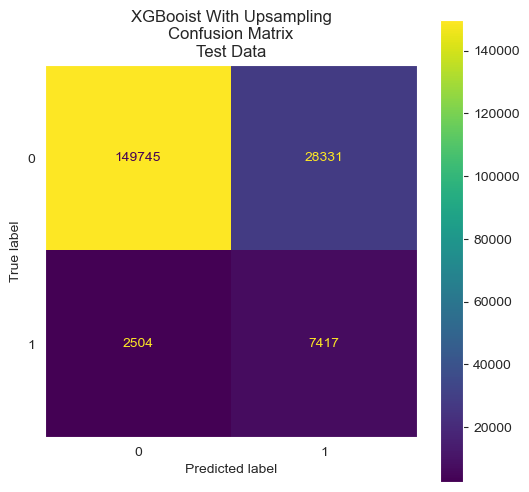

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.84      0.91    178076
           1       0.21      0.75      0.32      9921

    accuracy                           0.84    187997
   macro avg       0.60      0.79      0.62    187997
weighted avg       0.94      0.84      0.88    187997

Accuracy Score:
Train: 0.836
Test: 0.836 
Precision Score:
Train: 0.842
Test: 0.207 
Recall Score:
Train: 0.828
Test: 0.748 
F1 Score:
Train: 0.835
Test: 0.325 
AUC Score:
Train: 0.918
Test: 0.880 


In [501]:
###############
#MODEL FITTING#
###############

# Upsampled Data
xgb_upsampled = XGBClassifier(random_state=42)
xgb_upsampled.fit(X_train_scaled_upsampled, y_train_upsampled)

# Hard Predictions for train and test data
y_pred_train = xgb_upsampled.predict(X_train_scaled_upsampled)
y_pred_test = xgb_upsampled.predict(X_test_scaled_upsampled)

# Predicted probabilities for train and test data
y_pred_proba_train = xgb_upsampled.predict_proba(X_train_scaled_upsampled)[:, 1]
y_pred_proba_test = xgb_upsampled.predict_proba(X_test_scaled_upsampled)[:, 1]

##################
#Model Evaluation#
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(xgb_upsampled, X_test_scaled_upsampled, y_test)
plt.title('XGBooist With Upsampling\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test)
print('Test Data classification report: ', print_line, report_original)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_upsampled,y_pred_train):.3f}')
print(f'Test: {accuracy_score(y_test,y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_upsampled, y_pred_train):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_upsampled, y_pred_train):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_upsampled, y_pred_train):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_upsampled, y_pred_proba_train):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

### 9.3 XGBoost With Downsampling (scaled, without PCA) <a class="anchor" id="9c"></a>

Confusion Matrix: 


<Figure size 300x300 with 0 Axes>

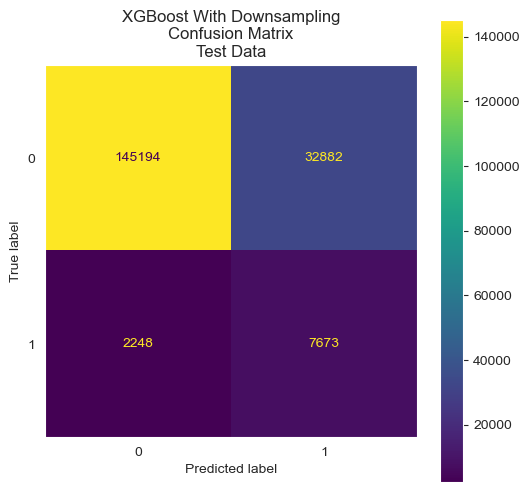

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.98      0.82      0.89    178076
           1       0.19      0.77      0.30      9921

    accuracy                           0.81    187997
   macro avg       0.59      0.79      0.60    187997
weighted avg       0.94      0.81      0.86    187997

Accuracy Score:
Train: 0.850
Test: 0.813 
Precision Score:
Train: 0.863
Test: 0.189 
Recall Score:
Train: 0.832
Test: 0.773 
F1 Score:
Train: 0.848
Test: 0.304 
AUC Score:
Train: 0.929
Test: 0.880 


In [426]:
###############
# MODEL FITTING #
###############

# Downsampled Data
xgb_downsampled = XGBClassifier(random_state=42)
xgb_downsampled.fit(X_train_scaled_downsampled, y_train_downsampled)

# Hard Predictions for train and test data
y_pred_train = xgb_downsampled.predict(X_train_scaled_downsampled)
y_pred_test = xgb_downsampled.predict(X_test_scaled_downsampled)

# Predicted probabilities for train and test data
y_pred_proba_train = xgb_downsampled.predict_proba(X_train_scaled_downsampled)[:, 1]
y_pred_proba_test = xgb_downsampled.predict_proba(X_test_scaled_downsampled)[:, 1]

##################
# MODEL EVALUATION #
##################

print_line = "\n" + "===========" * 6

# Display Confusion Matrix
print('Confusion Matrix:', print_line)
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(xgb_downsampled, X_test_scaled_downsampled, y_test)
plt.title('XGBoost With Downsampling\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Report
report_original = classification_report(y_test, y_pred_test)
print('Test Data Classification Report:', print_line, report_original)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_downsampled, y_pred_train):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_downsampled, y_pred_train):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_downsampled, y_pred_train):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_downsampled, y_pred_train):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_downsampled, y_pred_proba_train):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

#### Model Interpretation

The XGBoost model includes a feature importance metric that measures how much each feature contributes to the model's predictions. Features with higher importance scores are considered more impactful within the model. In this section, I will:
1. Find the top 30 features with the highest importance scores.
2. Visualize the most influential features.

In [427]:
# Get feature importances
xgb_importances = xgb_downsampled.feature_importances_

# Create a DataFrame with features and Feature importances
xgb_feature_importance_df = pd.DataFrame(
    xgb_importances.reshape(-1, 1),
    index=X_train_downsampled.columns,
    columns=['feature_importance']
)

# Sort by the feature importance and show the top five rows
xgb_feature_importance_df = xgb_feature_importance_df.sort_values(by='feature_importance', ascending=False)
xgb_feature_importance_df.head(5)

,feature_importance
had_angina,0.432769
difficulty_walking_Yes,0.049251
had_stroke,0.035960
had_diabetes_Yes,0.023044
age_category_25-29,0.020028


<Figure size 1500x1500 with 0 Axes>

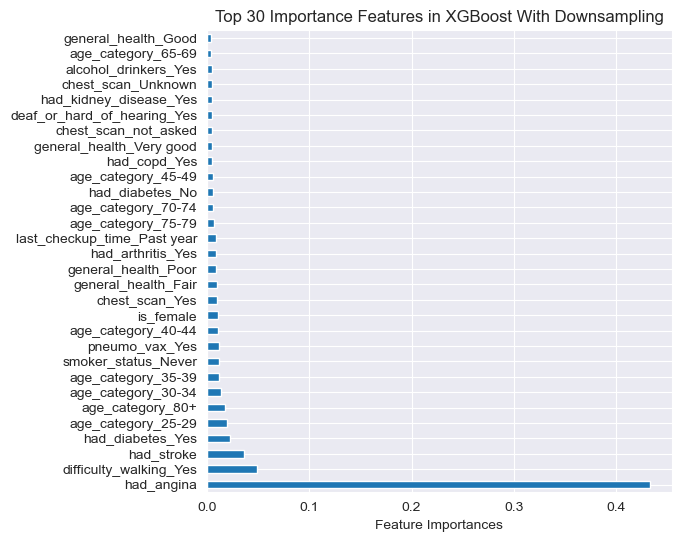

In [428]:
# Visualize the top 40 important features
plt.figure(figsize=(15, 15))
xgb_feature_importance_df.head(30).plot(kind='barh', legend=False)
plt.title('Top 30 Importance Features in XGBoost With Downsampling')
plt.xlabel('Feature Importances')

plt.show()

In [430]:
# Create a list of important features in XGBoost
xgb_important_features = xgb_feature_importance_df.head(30).index.tolist()

xgb_important_features

['had_angina',
 'difficulty_walking_Yes',
 'had_stroke',
 'had_diabetes_Yes',
 'age_category_25-29',
 'age_category_80+',
 'age_category_30-34',
 'age_category_35-39',
 'smoker_status_Never',
 'pneumo_vax_Yes',
 'age_category_40-44',
 'is_female',
 'chest_scan_Yes',
 'general_health_Fair',
 'general_health_Poor',
 'had_arthritis_Yes',
 'last_checkup_time_Past year',
 'age_category_75-79',
 'age_category_70-74',
 'had_diabetes_No',
 'age_category_45-49',
 'had_copd_Yes',
 'general_health_Very good',
 'chest_scan_not_asked',
 'deaf_or_hard_of_hearing_Yes',
 'had_kidney_disease_Yes',
 'chest_scan_Unknown',
 'alcohol_drinkers_Yes',
 'age_category_65-69',
 'general_health_Good']

**Takeaways**:
- Compared to the Random Forest model, fewer features contributed to the prediction of the target variable in the XGBoost model. Similarly, `had_angina` has the highest predicive power with the dominant importance value. The remaining features among the top 20 important features appear to have relatively little predictive power for the target variable.
- The presence of many irrelevant features likely contributes to the significant gap between the precision and F1 scores on the training and test datasets. Reducing or refining the feature set could help mitigate this issue and improve model generalization.

---

### 9.4 XGBoost Baseline Modeling Summary <a class="anchor" id="9d"></a>

**Metrics using test data:**<br>

| Model                   | Scaled | PCA | Accuracy | Precision | Recall | F1 Score | AUC   | Notes                       |
|-------------------------|--------|-----|----------|-----------|--------|----------|-------|-----------------------------|
| XGBoost    | Yes  | No  | 0.950  | 0.565 | 0.243 | 0.340 | 0.882 |Imbalanced  |      
| XGBoost | Yes | No  | 0.836 |0.207  |0.748 |0.325  |0.880  | Upsampled, overfitting  |
| **XGBoost**  |**Yes** | **No** | 0.813 |0.189  |0.773 |0.304  |0.880 | **Downsampled**,  overfitting |


- So far, hyperparameter tuning has not been conducted on any of the XGBoost models. Due to the tendency of Decision Trees to overfit the data, I have set the maximum depth to 7 across all baseline models. The models utilizing both upsampling and downsampling exhibit very similar performance, with the downsampling model achieving slightly better Recall metrics.
- All models with upsampling and downsampling exhibit sign of overfitting, where the Precision and F1 Score on the test data significanly underperforms compared to the scores on the train data, so feature selection should be performed later to improve generalization.
- In the model interpretation of XGBoost Model With Downsampling model, about 20 out of 149 features were found to significantly contribute to predicting the target. A vast number of unimportant features could potentially lead to overfitting, so reducing the feature could help improve generalization.


---

## 10. Comparison of Baseline Models and Summary <a class="anchor" id="10"></a>

### 10.1 Important/Predictive Features in Various Baseline Models <a class="anchor" id="10a"></a>

- During the baseline modeling stage, I identified the important or predictive features in Logistic Regression, Decision Tree, Random Forest, and XGBoost.
- In this section, I will combine all these important features to determine the total number of unique important features and count how many times each feature has occurred across the four models.

([<matplotlib.axis.XTick at 0x1ba84b79b10>,
 [Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3'), Text(4, 0, '4')])

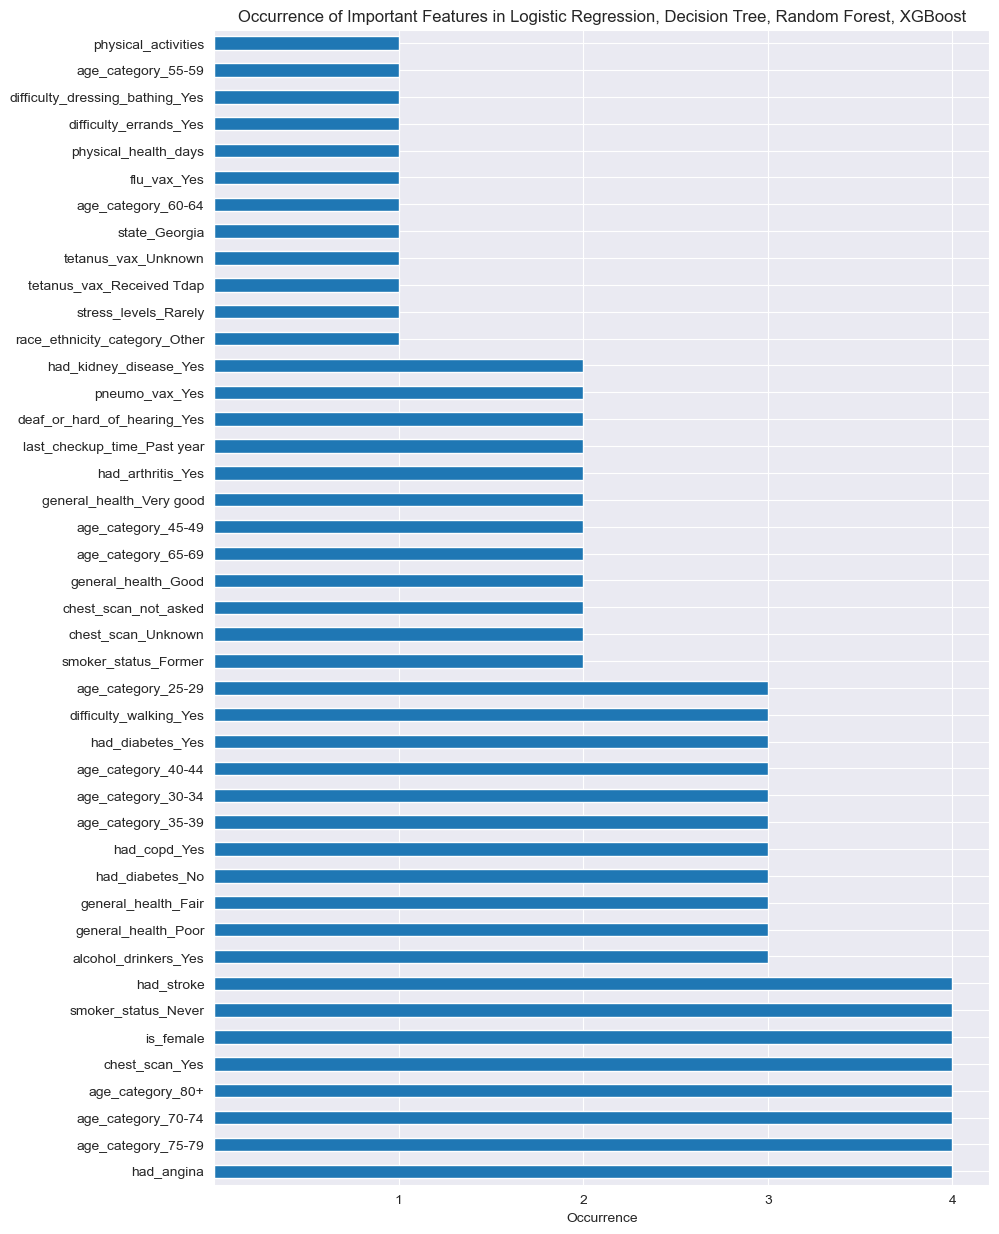

In [454]:
# Create a list of all important features
all_important_features = (
    logreg_important_features + 
    dt_important_features + 
    rf_important_features + 
    xgb_important_features
)

# Create a DataFrame of all important features
important_features_df = pd.DataFrame(all_important_features, columns=['Feature'])

# Count the appearance of important features in these four models
important_features_occurance = important_features_df['Feature'].value_counts()\
    .sort_values(ascending=False)

# Visualize 
plt.figure(figsize=(10, 15))
important_features_occurance.plot(kind='barh')
plt.title('Occurrence of Important Features in Logistic Regression, Decision Tree, Random Forest, XGBoost')
plt.xlabel('Occurrence')
plt.ylabel('')
plt.xticks(range(1, 5))

In [457]:
# Print the total number of features
print(f'Total number of features in baseline modeling: {X_train_encoded.shape[1]}')

# Print the number of all important features
print(f'Number of all important features: {len(important_features_occurance)}')

Total number of features in baseline modeling: 149
Number of all important features: 43


**Takeaways**:
- Despite aggregating all important features from four of the five classification models, fewer than 30% of the features are actually significant or predictive for the target variable, while the remaining 70% are considered unimportant. This significant number of excessive features poses a potential risk for overfitting in these models. Therefore, feature reduction and refinement should be prioritized in the next stage to enhance model performance.

---

### 10.2 Model Comparison and Summary <a class="anchor" id="10b"></a>

**Metrics using test data:**<br>
random_state=42 is applied to all models that  incorporate randomness.

| Model                  | X_train     | Hyperparameters                      | Scaled | PCA | Accuracy | Precision | Recall | F1 | AUC  | Notes                       |
|------------------------|-------------|--------------------------------------|--------|-----|----------|-----------|--------|----------|------|-----------------------------|
| Logistic Regression | Upsampled | max_iter=1000 | Yes    | No  | 0.832    | 0.206     | 0.763  | 0.325    | 0.885| Overfitting                 |
|Naive Bayes  | Downsampled  |  | Yes    | No  |0.747    | 0.145     | 0.778  | 0.245    | 0.824 | Overfitting |
| Decision Tree | Downsampled | max_depth=7  | Yes| No | 0.817  |0.189  | 0.749 |0.302  |0.854| Overfitting|
| Random Forest      |  Upsampled | n_estimators=50, max_depth=7  | Yes| No| 0.814|0.189 |0.762|0.302  |0.871| Overfitting|
| **XGBoost**      |  **Downsampled** |  | **Yes**| **No**| **0.813** |**0.189** |**0.773** |**0.304**  |**0.880**| **Overfitting**|


**Summary:**
1. Up to this stage, I have evaluated several baseline models, including Logistic Regression, Naive Bayes, Decision Tree, Random Forest, and XGBoost. For each model, I trained on both imbalanced data and balanced data using upsampling and downsampling techniques. The table below presents the best performer for each model based on performance metrics. 
2. Model performance is primarily assessed using the recall metric on the test dataset. In cases where multiple models yield similar recall scores, the model with the higher precision is selected as the best performer.
3. Among all baseline models, XGBoost with downsampling techniques is selected as the best performer. This model achieves a recall of 0.773, which is very close to the highest recall of 0.778 achieved by Naive Bayes; however, the XGBoost model exhibits a significantly higher precision score than Naive Bayes. 
4. No hyperparameter tuning was conducted during the baseline modeling phase; most hyperparameters were chosen based on intuition to help prevent overfitting and establish a fixed random seed.
5. All models that employed upsampling and downsampling techniques demonstrated signs of overfitting, as precision and F1 scores were considerably lower on the test data compared to the train data. This common issue suggests that feature reduction may be necessary.
6. I applied PCA to the best-performing models, specifically Logistic Regression and Decision Tree, to assess whether dimensionality reduction could help mitigate overfitting or enhance model performance. However, none of the models utilizing PCA showed improved performance or resolved the overfitting issue. During my analysis on reducing dimensionality with PCA, I discovered that it was not well-suited for this dataset, as it required over 110 principal components to achieve a total explained variance ratio of 90%
7. As noted previously, over 70% of features are deemed unimportant, contributing to potential overfitting. In the next phase, I will revisit feature engineering to identify and retain the most crucial features while filtering out the unimportant ones. Following this, I will re-evaluate the models to assess if overfitting can be mitigated.

---



## 11 Export Data <a class="anchor" id="11"></a>

Export the data with initial feature engineering.

In [460]:
# Export df_engineer
df_engineer.to_csv("../data/processed/heart_attack_with_initial_feature_engineering", index=False)